## Imports


In [1]:
import os
import time
import shutil
import requests
import csv
import base64
import json
from datetime import datetime

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import firebase_admin
from firebase_admin import credentials, firestore, storage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

import keras
from keras import layers
from keras.utils import to_categorical
from keras.regularizers import l1_l2
from keras.metrics import Precision, Recall, F1Score
from scikeras.wrappers import KerasClassifier

import tf2onnx
import onnx
import onnxruntime as ort

import pickle

2024-08-20 12:37:18.591179: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 12:37:18.773344: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 12:37:18.913693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 12:37:19.076120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 12:37:19.112242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 12:37:19.436657: I tensorflow/core/platform/cpu_feature_gu

In [2]:
np.set_printoptions(suppress=True)

In [3]:
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
base_root_directory = "./"
models_directory = os.path.join(base_root_directory, "models")

os.makedirs(models_directory, exist_ok=True)

## Connect to Firebase


In [5]:
if not firebase_admin._apps:
    cred = credentials.Certificate("serviceAccount.json")
    app = firebase_admin.initialize_app(cred)

In [6]:
db = firestore.client()
bucket = storage.bucket(name="sholat-ml.appspot.com")

## Fetch Datasets From Firestore


### Get datasets props


In [7]:
docs = (
    db.collection("datasets")
    .where("has_evaluated", "==", True)
    .where("dataset_version", "==", 4)
    .get()
)
data = [{"id": doc.id, **doc.to_dict()} for doc in docs]

/var/home/azlir/Projects/sholat-ml/sholat_ml_model/.venv/lib64/python3.12/site-packages/google/cloud/firestore_v1/base_collection.py:300: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/tmp/ipykernel_41385/537356059.py:4: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  .where("dataset_version", "==", 4)


In [8]:
dataset_prop_df = pd.DataFrame(data)
dataset_prop_df

id  dataset_prop_version  \
0   74x2B4HkOjvJdp0Cufg2                     4   
1   7vJsBJG7mnbcORPKmKel                     4   
2   9d8bZX5gIFcVfhbOqTeE                     4   
3   A6kRU2BP3OeE2mwkgsyo                     4   
4   AoachKOfCHGlTXFjeX9H                     4   
5   BOlkTJkX4UM8tCpUubHW                     4   
6   EnkOaBJtv7gPmzbHuXEB                     4   
7   F99mQ4BmGo1eHiG8dXod                     4   
8   J8qY9zDoQLO7v0byR1Bp                     4   
9   OACFPY46CheaLchBSgNC                     4   
10  XDKdx1J02Bm0hEbwEMDq                     4   
11  YLH0P1pPk8I0HwPBRIFa                     4   
12  aI4E8i8YkHltZs8U5NOf                     4   
13  dmSTe0mNiASiywpVqe6x                     4   
14  fOvL5fmqt7PEcamXKACs                     4   
15  kNqw6zb9tir2hXNzm6Qh                     4   
16  lMlA3nKILIWM0TEE56os                     4   
17  n5ejDgdJgAL4v8UPqnPQ                     4   
18  oVqYMYM7uSa5h0oWrfPD                     4   
19  qohcOMUxhvEsss4meNaF                     4   
20  wmXaCjHG5AgZT8JF2Zw8                     4   
21  zfphrsR7v2ypokxCvBk6                     4   

                                            video_url  \
0   https://firebasestorage.googleapis.com/v0/b/sh...   
1   https://firebasestorage.googleapis.com/v0/b/sh...   
2   https://firebasestorage.googleapis.com/v0/b/sh...   
3   https://firebasestorage.googleapis.com/v0/b/sh...   
4   https://firebasestorage.googleapis.com/v0/b/sh...   
5   https://firebasestorage.googleapis.com/v0/b/sh...   
6   https://firebasestorage.googleapis.com/v0/b/sh...   
7   https://firebasestorage.googleapis.com/v0/b/sh...   
8   https://firebasestorage.googleapis.com/v0/b/sh...   
9   https://firebasestorage.googleapis.com/v0/b/sh...   
10  https://firebasestorage.googleapis.com/v0/b/sh...   
11  https://firebasestorage.googleapis.com/v0/b/sh...   
12  https://firebasestorage.googleapis.com/v0/b/sh...   
13  https://firebasestorage.googleapis.com/v0/b/sh...   
14  https://firebasestorage.googleapis.com/v0/b/sh...   
15  https://firebasestorage.googleapis.com/v0/b/sh...   
16  https://firebasestorage.googleapis.com/v0/b/sh...   
17  https://firebasestorage.googleapis.com/v0/b/sh...   
18  https://firebasestorage.googleapis.com/v0/b/sh...   
19  https://firebasestorage.googleapis.com/v0/b/sh...   
20  https://firebasestorage.googleapis.com/v0/b/sh...   
21  https://firebasestorage.googleapis.com/v0/b/sh...   

                                              csv_url  is_compressed  \
0   https://firebasestorage.googleapis.com/v0/b/sh...           True   
1   https://firebasestorage.googleapis.com/v0/b/sh...           True   
2   https://firebasestorage.googleapis.com/v0/b/sh...          False   
3   https://firebasestorage.googleapis.com/v0/b/sh...           True   
4   https://firebasestorage.googleapis.com/v0/b/sh...           True   
5   https://firebasestorage.googleapis.com/v0/b/sh...          False   
6   https://firebasestorage.googleapis.com/v0/b/sh...          False   
7   https://firebasestorage.googleapis.com/v0/b/sh...           True   
8   https://firebasestorage.googleapis.com/v0/b/sh...           True   
9   https://firebasestorage.googleapis.com/v0/b/sh...           True   
10  https://firebasestorage.googleapis.com/v0/b/sh...          False   
11  https://firebasestorage.googleapis.com/v0/b/sh...          False   
12  https://firebasestorage.googleapis.com/v0/b/sh...          False   
13  https://firebasestorage.googleapis.com/v0/b/sh...          False   
14  https://firebasestorage.googleapis.com/v0/b/sh...           True   
15  https://firebasestorage.googleapis.com/v0/b/sh...           True   
16  https://firebasestorage.googleapis.com/v0/b/sh...           True   
17  https://firebasestorage.googleapis.com/v0/b/sh...          False   
18  https://firebasestorage.googleapis.com/v0/b/sh...          False   
19  https://firebasestorage.googleapis.com/v0/b/sh...           True   
20  https://firebasestorage.googleapis.com/v0/b

### Download datasets


In [9]:
def prepare_file_directory(directory_path, id):
    file_directory_path = os.path.join(directory_path, id)
    os.makedirs(file_directory_path, exist_ok=True)
    return file_directory_path

In [10]:
def download_file_from_url(url_str, download_folder, use_cache=True):
    filename = "dataset.csv"
    download_file_path = os.path.join(download_folder, filename)

    if not os.path.exists(download_file_path) or not use_cache:
        r = requests.get(url_str, allow_redirects=True)
        if r.status_code == 200:
            open(download_file_path, "wb").write(r.content)
            return True
        else:
            print(
                "Failed to download {} with status {}".format(
                    download_file_path, r.status_code
                )
            )
            return False
    else:
        print("File {} already exists".format(download_file_path))
        return False

In [11]:
def download_dataset(entry, dest_dir_path):
    id = entry.id
    url = entry.csv_url
    downloaded_file_dir = prepare_file_directory(dest_dir_path, id)
    result = download_file_from_url(url, downloaded_file_dir)
    return result

In [12]:
def download_all_datasets(entries, use_cache=True):
    dest_dir_path = "datasets/raw_datasets"

    if use_cache == False:
        if os.path.exists(dest_dir_path):
            shutil.rmtree(dest_dir_path)

    succeed_download = 0
    with ThreadPoolExecutor() as executor:
        futures = []
        for entry in entries:
            future = executor.submit(download_dataset, entry, dest_dir_path)
            futures.append(future)
        for future in tqdm(futures, desc="Downloading datasets", total=len(entries)):
            result = future.result()
            if result is True:
                succeed_download += 1
    print("\nSucceed download: {}".format(succeed_download))

In [13]:
entries = list(dataset_prop_df[["id", "csv_url"]].itertuples())
download_all_datasets(entries, use_cache=True)

File datasets/raw_datasets/EnkOaBJtv7gPmzbHuXEB/dataset.csv already exists
File datasets/raw_datasets/74x2B4HkOjvJdp0Cufg2/dataset.csv already exists
File datasets/raw_datasets/A6kRU2BP3OeE2mwkgsyo/dataset.csv already exists
File datasets/raw_datasets/AoachKOfCHGlTXFjeX9H/dataset.csv already exists
File datasets/raw_datasets/7vJsBJG7mnbcORPKmKel/dataset.csv already exists
File datasets/raw_datasets/BOlkTJkX4UM8tCpUubHW/dataset.csv already exists
File datasets/raw_datasets/9d8bZX5gIFcVfhbOqTeE/dataset.csv already exists
File datasets/raw_datasets/J8qY9zDoQLO7v0byR1Bp/dataset.csv already exists
File datasets/raw_datasets/OACFPY46CheaLchBSgNC/dataset.csv already exists
File datasets/raw_datasets/XDKdx1J02Bm0hEbwEMDq/dataset.csv already exists
File datasets/raw_datasets/YLH0P1pPk8I0HwPBRIFa/dataset.csv already exists
File datasets/raw_datasets/aI4E8i8YkHltZs8U5NOf/dataset.csv already exists
File datasets/raw_datasets/F99mQ4BmGo1eHiG8dXod/dataset.csv already exists
File datasets/raw_dataset


Succeed download: 0


## Extract datasets


### Separate Files for Each Movement Set (not used)


In [14]:
def process_csv(file_path, dest_dir_path):
    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)

        for index, row in enumerate(reader):
            (
                timestamp,
                x,
                y,
                z,
                heart_rate,
                movement_set_id,
                note,
                label_category,
                label,
                noise,
                _,
            ) = row

            if any(value == "" for value in [movement_set_id, label_category, label]):
                continue

            output_dir_path = os.path.join(dest_dir_path, label_category, label)
            output_file_path = os.path.join(output_dir_path, f"{movement_set_id}.csv")

            os.makedirs(output_dir_path, exist_ok=True)

            if index == 0 and os.path.exists(output_file_path):
                print(
                    f"WARNING: multiple movement_set_id detected in different file with id: {movement_set_id}"
                )
                return

            with open(output_file_path, "a") as new_csv_file:
                row_str = ", ".join(row)
                new_csv_file.write(f"{row_str}\n")

In [15]:
def group_csv_by_movement_set_id(source_dir_path, dest_dir_path):
    if os.path.exists(dest_dir_path):
        shutil.rmtree(dest_dir_path)

    for root, directories, files in tqdm(
        os.walk(source_dir_path), desc="Grouping datasets by movement set ID"
    ):
        for filename in files:
            if filename.endswith(".csv"):
                file_path = os.path.join(root, filename)
                process_csv(file_path, dest_dir_path)

In [16]:
group_csv_by_movement_set_id(
    source_dir_path="datasets/raw_datasets",
    dest_dir_path="datasets/grouped_datasets",
)

Grouping datasets by movement set ID: 23it [00:06,  3.48it/s]


### Single Appended File (used)


#### Appending


In [14]:
def append_csv(file_path, dest_file_path):
    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)

        with open(dest_file_path, "a", newline="") as new_csv_file:
            writer = csv.writer(new_csv_file)

            for row in reader:
                # Assuming the first row might be headers; skip if necessary
                if reader.line_num == 1:
                    continue  # Skip header row, remove this line if no headers

                (
                    timestamp,
                    x,
                    y,
                    z,
                    heart_rate,
                    movement_set_id,
                    note,
                    label_category,
                    label,
                    noise,
                    _,
                ) = row

                if any(
                    value == "" for value in [movement_set_id, label_category, label]
                ):
                    continue

                writer.writerow(row)

In [15]:
def append_datasets_into_single_file(source_dir_path, dest_dir_path, use_cache=True):
    if use_cache == False:
        if os.path.exists(dest_dir_path):
            shutil.rmtree(dest_dir_path)
    else:
        print("File {} already exists".format(dest_dir_path))
        return

    os.makedirs(dest_dir_path, exist_ok=True)

    all_files = []

    for root, directories, files in os.walk(source_dir_path):
        for filename in files:
            if filename.endswith(".csv"):
                file_path = os.path.join(root, filename)
                all_files.append(file_path)

    all_files.sort()

    for file_path in tqdm(all_files, desc="Appending datasets into a single file"):
        append_csv(file_path, f"{dest_dir_path}/datasets.csv")

In [16]:
append_datasets_into_single_file(
    source_dir_path="datasets/raw_datasets",
    dest_dir_path="datasets/single_file_dataset",
    use_cache=False,
)

Appending datasets into a single file: 100%|██████████| 22/22 [00:00<00:00, 35.72it/s]


#### Check CSV Integrity


In [17]:
import hashlib


def calculate_sha1(file_path):
    sha1 = hashlib.sha1()
    with open(file_path, "rb") as file:
        while chunk := file.read(8192):
            sha1.update(chunk)
    return sha1.hexdigest()


csv_path = "datasets/single_file_dataset/datasets.csv"
csv_sha1 = calculate_sha1(csv_path)
print(f"SHA-1: {csv_sha1}")

SHA-1: f0e0a3e105fe50614a9e5bf8719da89c89f6a2a8


In [18]:
def verify_file_sha1(file_path, known_sha1):
    file_sha1 = calculate_sha1(file_path)
    return file_sha1 == known_sha1


known_sha1 = "f0e0a3e105fe50614a9e5bf8719da89c89f6a2a8"
is_valid = verify_file_sha1(csv_path, known_sha1)

if is_valid:
    print(
        "\033[92m"
        + "✔ The file is valid and its SHA-1 hash matches the known hash."
        + "\033[0m"
    )
else:
    print(
        "\033[91m"
        + "✘ The file's SHA-1 hash does not match the known hash."
        + "\033[0m"
    )
    raise ValueError("The file's SHA-1 hash does not match the known hash.")

✔ The file is valid and its SHA-1 hash matches the known hash.


## Load Datasets


In [19]:
columns = [
    "timestamp",
    "x",
    "y",
    "z",
    "heart_rate",
    "movement_set_id",
    "note",
    "label_category",
    "label",
    "noise",
]
dtypes = {
    "timestamp": int,
    "x": float,
    "y": float,
    "z": float,
    "heart_rate": float,
    "movement_set_id": str,
    "note": str,
    "label_category": str,
    "label": str,
    "noise": str,
}

datasets_df = pd.read_csv(
    "datasets/single_file_dataset/datasets.csv",
    names=columns,
    dtype=dtypes,
    index_col=False,
)
datasets_df.head()

timestamp       x       y      z  heart_rate  \
0       3407  3762.0  1850.0 -319.0         NaN   
1       3446  4046.0  1869.0  113.0         NaN   
2       3485  3997.0  2298.0  257.0         NaN   
3       3524  4279.0  2864.0  364.0         NaN   
4       3563  4396.0  3455.0  638.0         NaN   

                        movement_set_id note label_category            label  \
0  528474d1-5876-49bc-916d-dd880d900134  NaN         takbir  takbiratulihram   
1  528474d1-5876-49bc-916d-dd880d900134  NaN         takbir  takbiratulihram   
2  528474d1-5876-49bc-916d-dd880d900134  NaN         takbir  takbiratulihram   
3  528474d1-5876-49bc-916d-dd880d900134  NaN         takbir  takbiratulihram   
4  528474d1-5876-49bc-916d-dd880d900134  NaN         takbir  takbiratulihram   

  noise  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

In [20]:
len(datasets_df)

142676

### Remove Noise


In [21]:
datasets_df[
    ~pd.isna(datasets_df["noise"]) | (datasets_df["label"] == "duduk_antara_dua_sujud")
].head()

timestamp       x       y       z  heart_rate  \
3483      71855  1614.0  2582.0  2723.0        49.0   
3484      71893  1682.0  2672.0  2758.0        49.0   
3485      71931  1622.0  2787.0  2645.0        49.0   
3486      71969  1624.0  2750.0  2681.0        49.0   
3487      72007  1632.0  2743.0  2723.0        49.0   

                           movement_set_id note label_category  \
3483  ad5435ac-ff78-4ccf-8646-3f99f3e8de6f  NaN          duduk   
3484  ad5435ac-ff78-4ccf-8646-3f99f3e8de6f  NaN          duduk   
3485  ad5435ac-ff78-4ccf-8646-3f99f3e8de6f  NaN          duduk   
3486  ad5435ac-ff78-4ccf-8646-3f99f3e8de6f  NaN          duduk   
3487  ad5435ac-ff78-4ccf-8646-3f99f3e8de6f  NaN          duduk   

                       label noise  
3483  duduk_antara_dua_sujud   NaN  
3484  duduk_antara_dua_sujud   NaN  
3485  duduk_antara_dua_sujud   NaN  
3486  duduk_antara_dua_sujud   NaN  
3487  duduk_antara_dua_sujud   NaN

In [22]:
ids_to_remove = datasets_df.loc[
    ~pd.isna(datasets_df["noise"]) | (datasets_df["label"] == "duduk_antara_dua_sujud"),
    "movement_set_id",
].unique()
datasets_df = datasets_df[~datasets_df["movement_set_id"].isin(ids_to_remove)]

In [23]:
len(ids_to_remove)

82

### Balance Datasets


In [24]:
datasets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125574 entries, 0 to 142675
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp        125574 non-null  int64  
 1   x                125574 non-null  float64
 2   y                125574 non-null  float64
 3   z                125574 non-null  float64
 4   heart_rate       120674 non-null  float64
 5   movement_set_id  125574 non-null  object 
 6   note             0 non-null       object 
 7   label_category   125574 non-null  object 
 8   label            125574 non-null  object 
 9   noise            0 non-null       object 
dtypes: float64(4), int64(1), object(5)
memory usage: 10.5+ MB


In [25]:
raw_df = datasets_df[
    ["timestamp", "label_category", "label", "movement_set_id", "x", "y", "z"]
].copy()
raw_df.head()

timestamp label_category            label  \
0       3407         takbir  takbiratulihram   
1       3446         takbir  takbiratulihram   
2       3485         takbir  takbiratulihram   
3       3524         takbir  takbiratulihram   
4       3563         takbir  takbiratulihram   

                        movement_set_id       x       y      z  
0  528474d1-5876-49bc-916d-dd880d900134  3762.0  1850.0 -319.0  
1  528474d1-5876-49bc-916d-dd880d900134  4046.0  1869.0  113.0  
2  528474d1-5876-49bc-916d-dd880d900134  3997.0  2298.0  257.0  
3  528474d1-5876-49bc-916d-dd880d900134  4279.0  2864.0  364.0  
4  528474d1-5876-49bc-916d-dd880d900134  4396.0  3455.0  638.0

In [26]:
raw_df["label_category"].value_counts()

label_category
berdiri     36900
transisi    32353
duduk       22242
sujud       11711
qunut        8760
ruku         4973
takbir       4856
iktidal      3779
Name: count, dtype: int64

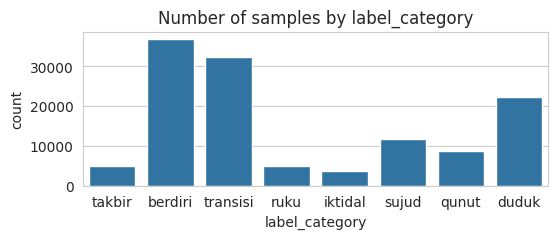

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 2))
sns.countplot(data=raw_df, x="label_category")
plt.title("Number of samples by label_category")
plt.show()

In [28]:
raw_df.groupby("label_category")["movement_set_id"].nunique()

label_category
berdiri      45
duduk        23
iktidal      61
qunut        13
ruku         61
sujud       111
takbir       40
transisi    393
Name: movement_set_id, dtype: int64

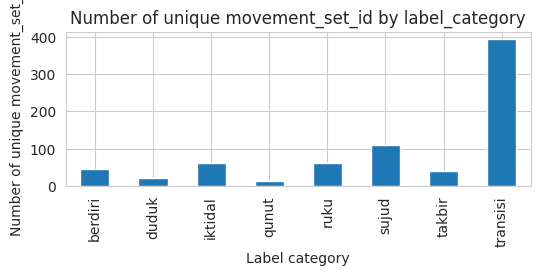

In [29]:
counts = raw_df.groupby("label_category")["movement_set_id"].nunique()

sns.set_style("whitegrid")
plt.figure(figsize=(6, 2))
counts.plot.bar()
plt.title("Number of unique movement_set_id by label_category")
plt.xlabel("Label category")
plt.ylabel("Number of unique movement_set_id")
plt.show()

In [30]:
def balance_data(df, target_length):
    balanced_data = pd.DataFrame(columns=df.columns)

    for category in df["label_category"].unique():
        category_df = df[df["label_category"] == category]
        category_length = len(category_df)

        if category_length > target_length:
            if category not in ["qunut", "berdiri", "sujud", "ruku", "duduk"]:
                category_df = category_df.head(target_length)
            else:
                percentage = target_length / category_length

                balanced_category_by_id = pd.DataFrame(columns=df.columns)

                for movement_id in category_df["movement_set_id"].unique():
                    category_by_id_df = category_df[
                        category_df["movement_set_id"] == movement_id
                    ]
                    num_rows_to_drop_per_group = int(
                        percentage * len(category_by_id_df)
                    )
                    dropped_category_by_id = category_by_id_df.head(
                        num_rows_to_drop_per_group
                    )
                    balanced_category_by_id = pd.concat(
                        [balanced_category_by_id, dropped_category_by_id]
                    )

                category_df = balanced_category_by_id.copy()

        balanced_data = pd.concat([balanced_data, category_df])

    return balanced_data

In [31]:
target_length = 5731

df = balance_data(raw_df, target_length)
# df = raw_df

/tmp/ipykernel_41385/747924600.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_data = pd.concat([balanced_data, category_df])
/tmp/ipykernel_41385/747924600.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_category_by_id = pd.concat(
/tmp/ipykernel_41385/747924600.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result d

In [32]:
df["label_category"].value_counts()

label_category
transisi    5731
qunut       5722
duduk       5722
berdiri     5709
sujud       5672
ruku        4973
takbir      4856
iktidal     3779
Name: count, dtype: int64

In [33]:
df.groupby("label_category")["movement_set_id"].nunique()

label_category
berdiri      45
duduk        23
iktidal      61
qunut        13
ruku         61
sujud       111
takbir       40
transisi     75
Name: movement_set_id, dtype: int64

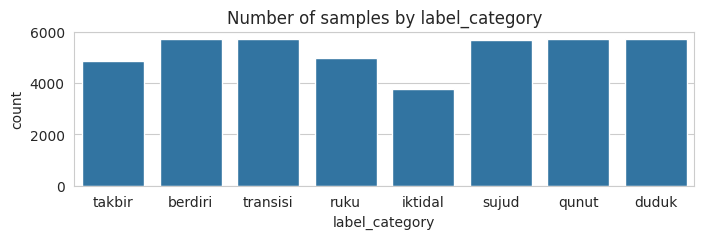

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 2))
sns.countplot(data=df, x="label_category")
plt.title("Number of samples by label_category")
plt.show()

In [35]:
df["movement_set_id"].nunique()

429

## Transform Datasets


### Splitting Datasets


In [36]:
def stratified_group_split(df, train_size=0.8, random_state=None):
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for category, group_df in df.groupby("label_category"):
        train_ids, test_ids = train_test_split(
            group_df["movement_set_id"].unique(),
            train_size=train_size,
            random_state=random_state,
        )

        train_group = group_df[group_df["movement_set_id"].isin(train_ids)]
        test_group = group_df[group_df["movement_set_id"].isin(test_ids)]

        train_df = pd.concat([train_df, train_group])
        test_df = pd.concat([test_df, test_group])

    return train_df, test_df

In [37]:
train_df, temp_df = stratified_group_split(df, train_size=0.8, random_state=42)
# train_df, temp_df = stratified_group_split(df_normalized, train_size=0.75, random_state=42)
val_df, test_df = stratified_group_split(temp_df, train_size=0.6, random_state=42)

# train_df, test_df = stratified_group_split(df, train_size=0.8, random_state=42)

In [38]:
val_df.head()

timestamp label_category       label  \
26075    214242        berdiri  bersedekap   
26076    214280        berdiri  bersedekap   
26077    214319        berdiri  bersedekap   
26078    214357        berdiri  bersedekap   
26079    214395        berdiri  bersedekap   

                            movement_set_id      x       y       z  
26075  1a682dec-a956-4525-b75c-36e1b288359c -642.0  3632.0 -2012.0  
26076  1a682dec-a956-4525-b75c-36e1b288359c -655.0  3510.0 -1890.0  
26077  1a682dec-a956-4525-b75c-36e1b288359c -637.0  3527.0 -1928.0  
26078  1a682dec-a956-4525-b75c-36e1b288359c -553.0  3544.0 -1949.0  
26079  1a682dec-a956-4525-b75c-36e1b288359c -602.0  3467.0 -1870.0

In [39]:
train_df.groupby("label_category")["movement_set_id"].nunique()

label_category
berdiri     36
duduk       18
iktidal     48
qunut       10
ruku        48
sujud       88
takbir      32
transisi    60
Name: movement_set_id, dtype: int64

In [40]:
val_df.groupby("label_category")["movement_set_id"].nunique()

label_category
berdiri      5
duduk        3
iktidal      7
qunut        1
ruku         7
sujud       13
takbir       4
transisi     9
Name: movement_set_id, dtype: int64

In [41]:
test_df.groupby("label_category")["movement_set_id"].nunique()

label_category
berdiri      4
duduk        2
iktidal      6
qunut        2
ruku         6
sujud       10
takbir       4
transisi     6
Name: movement_set_id, dtype: int64

### Generate Segements and Labels


In [42]:
LABEL_CATEGORIES = {
    0: "takbir",
    1: "berdiri",
    2: "ruku",
    3: "iktidal",
    4: "qunut",
    5: "sujud",
    6: "duduk",
    7: "transisi",
}
LABELS = np.array(list(LABEL_CATEGORIES.values()))
n_classes = len(LABELS)

categories = [LABELS]
one_hot_encoder = OneHotEncoder(
    categories=categories, handle_unknown="ignore", dtype=float
)

In [43]:
def create_segments_and_labels(
    df, window_size, window_step, label_name, one_hot_encoder
):
    num_samples = (len(df) - window_size) // window_step + 1
    segments = np.zeros((num_samples, window_size, 3))
    labels = np.zeros(num_samples, dtype=object)

    for i in range(num_samples):
        start = i * window_step
        end = start + window_size
        segments[i] = df[["x", "y", "z"]].values[start:end]
        labels[i] = df[label_name][start:end].mode()[0]

    one_hot_labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()
    return segments, one_hot_labels

## Modeling


### Utils


#### Visualising


In [44]:
def confusion_matrix(directory_path, label_categories, Y_true, Y_pred, savefig=True):
    Y_true = pd.Series([label_categories[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([label_categories[y] for y in np.argmax(Y_pred, axis=1)])

    confusion_matrix_df = (
        pd.crosstab(
            Y_true, Y_pred, rownames=["True"], colnames=["Pred"], normalize="index"
        )
        * 100
    )

    plt.figure(figsize=(7, 4))
    sns.heatmap(confusion_matrix_df, annot=True, fmt=".3g", cmap="Blues")
    plt.title("Confusion Matrix (%)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plot_file = os.path.join(directory_path, "confusion_matrix.png")

    if savefig == True:
        plt.savefig(plot_file, bbox_inches="tight")

    plt.show()

In [45]:
def confusion_matrix_with_filter(
    directory_path,
    model,
    window_size,
    window_step,
    label_categories,
    filter_field,
    value,
):
    X_filtered, Y_filtered = create_segments_and_labels(
        df[df[filter_field] == value],
        window_size,
        window_step,
        filter_field,
        one_hot_encoder,
    )
    return confusion_matrix(
        directory_path,
        label_categories,
        Y_filtered,
        model.predict(X_filtered),
        savefig=False,
    )

In [46]:
def plot_history(directory_path, history):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

    epochs = range(1, len(history["loss"]) + 1)

    # Find the best epoch based on validation loss
    best_loss_epoch = np.argmin(history["val_loss"]) + 1

    # Plot Loss
    ax1 = axes[0, 0]
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    ax1.plot(epochs, train_loss, label="Train")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Model Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    best_loss_value = val_loss[best_loss_epoch - 1]
    ax1.axvline(
        best_loss_epoch,
        linestyle="--",
        color="r",
        label=f"Best Epoch (Loss): {best_loss_epoch} ({best_loss_value:.4f})",
    )
    ax1.legend()

    # Plot Accuracy
    ax4 = axes[0, 1]
    train_acc = history["accuracy"]
    val_acc = history["val_accuracy"]
    ax4.plot(epochs, train_acc, label="Train")
    ax4.plot(epochs, val_acc, label="Validation")
    ax4.set_title("Model Accuracy")
    ax4.set_ylabel("Accuracy")
    ax4.set_xlabel("Epoch")
    ax4.set_ylim(0, 1)
    ax4.legend()

    best_acc_value = val_acc[best_loss_epoch - 1]
    ax4.axvline(
        best_loss_epoch,
        linestyle="--",
        color="r",
        label=f"Accuracy by best loss epoch: {best_acc_value:.4f}",
    )
    ax4.legend()

    # Plot F1 Score
    ax5 = axes[0, 2]
    train_f1 = history["f1_score"]
    val_f1 = history["val_f1_score"]
    ax5.plot(epochs, train_f1, label="Train")
    ax5.plot(epochs, val_f1, label="Validation")
    ax5.set_title("Model F1 Score")
    ax5.set_ylabel("F1 Score")
    ax5.set_xlabel("Epoch")
    ax5.set_ylim(0, 1)
    ax5.legend()

    best_f1_value = val_f1[best_loss_epoch - 1]
    ax5.axvline(
        best_loss_epoch,
        linestyle="--",
        color="r",
        label=f"F1 Score by best loss epoch: {best_f1_value:.4f}",
    )
    ax5.legend()

    # Plot Recall
    ax2 = axes[1, 0]
    train_recall = history["recall"]
    val_recall = history["val_recall"]
    ax2.plot(epochs, train_recall, label="Train")
    ax2.plot(epochs, val_recall, label="Validation")
    ax2.set_title("Model Recall")
    ax2.set_ylabel("Recall")
    ax2.set_xlabel("Epoch")
    ax2.set_ylim(0, 1)
    ax2.legend()

    best_recall_value = val_recall[best_loss_epoch - 1]
    ax2.axvline(
        best_loss_epoch,
        linestyle="--",
        color="r",
        label=f"Recall by best loss epoch: {best_recall_value:.4f}",
    )
    ax2.legend()

    # Plot Precision
    ax3 = axes[1, 1]
    train_precision = history["precision"]
    val_precision = history["val_precision"]
    ax3.plot(epochs, train_precision, label="Train")
    ax3.plot(epochs, val_precision, label="Validation")
    ax3.set_title("Model Precision")
    ax3.set_ylabel("Precision")
    ax3.set_xlabel("Epoch")
    ax3.set_ylim(0, 1)
    ax3.legend()

    best_precision_value = val_precision[best_loss_epoch - 1]
    ax3.axvline(
        best_loss_epoch,
        linestyle="--",
        color="r",
        label=f"Precision by best loss epoch: {best_precision_value:.4f}",
    )
    ax3.legend()

    # Hide the unused subplot (axes[1, 2])
    axes[1, 2].axis("off")

    plt.tight_layout()

    plot_file = os.path.join(directory_path, "plot_history.png")
    plt.savefig(plot_file, bbox_inches="tight")

    plt.show()

#### Saving


In [47]:
def save_model_as_keras(model, history, directory_path):
    os.makedirs(directory_path, exist_ok=True)

    history_file = os.path.join(directory_path, "history.pkl")

    with open(history_file, "wb") as file:
        pickle.dump(history, file)

    model_path = os.path.join(directory_path, "model.keras")
    model.save(model_path)

    return model_path

In [48]:
def save_model_as_onnx(model_directory, input_signature):
    model_path = os.path.join(model_directory, "model.keras")
    onnx_saved_path = os.path.join(model_directory, "model.onnx")

    model = keras.models.load_model(model_path)
    model.output_names = ["output"]

    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
    onnx.save(onnx_model, onnx_saved_path)

    return onnx_saved_path

In [49]:
def upload_folder_to_storage(directory_path, base_storage_path):
    file_urls = {}
    uploaded_files = []
    try:
        for root, _, files in os.walk(directory_path):
            for file in files:
                local_path = os.path.join(root, file)
                relative_path = os.path.relpath(local_path, directory_path)
                storage_path = os.path.join(base_storage_path, relative_path)
                file_url = upload_to_storage(local_path, storage_path)
                file_urls[relative_path] = file_url
                uploaded_files.append(storage_path)
        return file_urls, uploaded_files
    except Exception as e:
        print(f"An error occurred during file upload: {e}")
        delete_files_from_storage(uploaded_files)
        raise


def upload_to_storage(local_path, storage_path):
    blob = bucket.blob(storage_path)
    blob.upload_from_filename(local_path)
    blob.make_public()
    return blob.public_url


def delete_files_from_storage(files):
    for file in files:
        blob = bucket.blob(file)
        blob.delete()


def upload_to_firebase(directory_path, window_size):
    if not os.path.exists(directory_path):
        return

    evaluation_result_path = os.path.join(directory_path, "evaluation_result.json")

    models_doc = db.collection("models").document()

    try:
        file_urls, uploaded_files = upload_folder_to_storage(
            directory_path=directory_path, base_storage_path=f"models/{models_doc.id}"
        )

        with open(evaluation_result_path, "r") as json_file:
            evaluation_result = json.load(json_file)

        model_data = {
            "name": os.path.basename(os.path.normpath(directory_path)),
            "model_configuration": {
                "window_size": window_size,
                "window_step": 10,
            },
            "evaluation_metrics": {
                "loss": evaluation_result["loss"],
                "recall": evaluation_result["recall"],
                "precision": evaluation_result["precision"],
                "f1_score": evaluation_result["f1_score"],
                "accuracy": evaluation_result["accuracy"],
            },
            "files": file_urls,
            "created_at": firestore.SERVER_TIMESTAMP,
        }
        models_doc.set(model_data)
    except Exception as e:
        print(f"An error occurred: {e}")
        delete_files_from_storage(uploaded_files)
        raise

#### Training


In [50]:
def format_metrics(metrics):
    formatted = {}
    for key, value in metrics.items():
        if key == "loss":
            formatted[key] = f"{round(value, 4):.4f}"
        else:
            rounded_value = round(value * 100, 2)
            formatted[key] = f"{rounded_value:.2f}%"
    return formatted

def start_train(
    model,
    X_train,
    Y_train,
    X_test,
    Y_test,
    X_val,
    Y_val,
    use_cache,
    epochs=100,
    batch_size=32,
    verbose=1,
):

    directory_path = os.path.join(models_directory, model.name)
    checkpoint_path = os.path.join(directory_path, "model.weights.h5")
    history_path = os.path.join(directory_path, "history.pkl")
    evaluation_path = os.path.join(directory_path, "evaluation_result.json")
    model_path = os.path.join(directory_path, "model.keras")
    model_onnx_path = os.path.join(directory_path, "model.onnx")

    if use_cache == True:
        if (
            not os.path.exists(directory_path)
            or not os.path.exists(checkpoint_path)
            or not os.path.exists(model_path)
            or not os.path.exists(history_path)
            or not os.path.exists(evaluation_path)
        ):
            use_cache = False

    if use_cache == True:
        with open(history_path, "rb") as f:
            history = pickle.load(f)
    else:
        if os.path.exists(directory_path):
            shutil.rmtree(directory_path)

        model_checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=verbose,
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        start_time = time.time()
        history = model.fit(
            X_train,
            Y_train,
            batch_size,
            epochs,
            verbose=verbose,
            validation_data=(X_test, Y_test),
            callbacks=[early_stopping, model_checkpoint],
        ).history
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training took {training_time:.2f} seconds")

    total_epochs = len(history["loss"])
    print(f"Total epochs: {total_epochs}")

    plot_history(directory_path, history)

    model.load_weights(checkpoint_path)
    evaluation_results = model.evaluate(X_val, Y_val)

    evaluation_json = {
        "loss": evaluation_results[0],
        "recall": evaluation_results[1],
        "precision": evaluation_results[2],
        "accuracy": evaluation_results[3],
        "f1_score": evaluation_results[4],
    }

    with open(evaluation_path, "w") as json_file:
        json.dump(evaluation_json, json_file)

    print("\n=== Evaluation Metrics ===")
    formatted_metrics = format_metrics(evaluation_json)
    for key, value in formatted_metrics.items():
        print(f"{key}: {value}")

    print("\n=== Confusion Matrix ===")
    confusion_matrix(directory_path, LABEL_CATEGORIES, Y_val, model.predict(X_val))

    if use_cache == False:
        print("\nSaving model as keras...")
        keras_saved_path = save_model_as_keras(model, history, directory_path)
        print(f"Keras model saved successfully in {keras_saved_path}")

    if use_cache == False or not os.path.exists(model_onnx_path):
        input_shape = model.input_shape

        input_signature = [tf.TensorSpec(input_shape, tf.float32, name="x")]

        print("\nSaving model as ONNX...")
        onnx_saved_path = save_model_as_onnx(directory_path, input_signature)
        print(f"ONNX model saved successfully in {onnx_saved_path}")

    print("\n=== Done! ===")

    return directory_path

### Configuration


In [51]:
def generate_dynamic_window_data(window_size):
    window_step = 10

    X_train, Y_train = create_segments_and_labels(
        train_df,
        window_size,
        window_step,
        "label_category",
        one_hot_encoder,
    )
    X_test, Y_test = create_segments_and_labels(
        test_df,
        window_size,
        window_step,
        "label_category",
        one_hot_encoder,
    )
    X_val, Y_val = create_segments_and_labels(
        val_df,
        window_size,
        window_step,
        "label_category",
        one_hot_encoder,
    )

    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [52]:
X_train_10, Y_train_10, X_test_10, Y_test_10, X_val_10, Y_val_10 = (
    generate_dynamic_window_data(10)
)
X_train_20, Y_train_20, X_test_20, Y_test_20, X_val_20, Y_val_20 = (
    generate_dynamic_window_data(20)
)
X_train_30, Y_train_30, X_test_30, Y_test_30, X_val_30, Y_val_30 = (
    generate_dynamic_window_data(30)
)
X_train_40, Y_train_40, X_test_40, Y_test_40, X_val_40, Y_val_40 = (
    generate_dynamic_window_data(40)
)

In [53]:
f1 = F1Score(average="micro", threshold=0.5)
recall = Recall(name="recall")
precision = Precision(name="precision")

### Model 0 (Bidirectional LSTM) - Myria


#### Configuration


In [54]:
def create_model_0(model_name, window_size, n_hidden=64):
    input_dim = 3
    pv = 0.2

    return keras.Sequential(
        name=model_name,
        layers=[
            layers.Input(shape=(window_size, input_dim)),
            layers.Bidirectional(
                layers.LSTM(n_hidden, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
            ),
            layers.Dropout(pv),
            layers.Dense(n_classes, activation="softmax"),
        ],
    )

#### 10ws


In [57]:
model_0_10ws_name = "model_0_myria-10ws"

model_0_10ws = create_model_0(
    model_name=model_0_10ws_name,
    window_size=10,
)

model_0_10ws.summary()

model_0_10ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_0_myria-10ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               34816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 35848 (140.03 KB)
Trainable params: 35848 (140.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 105


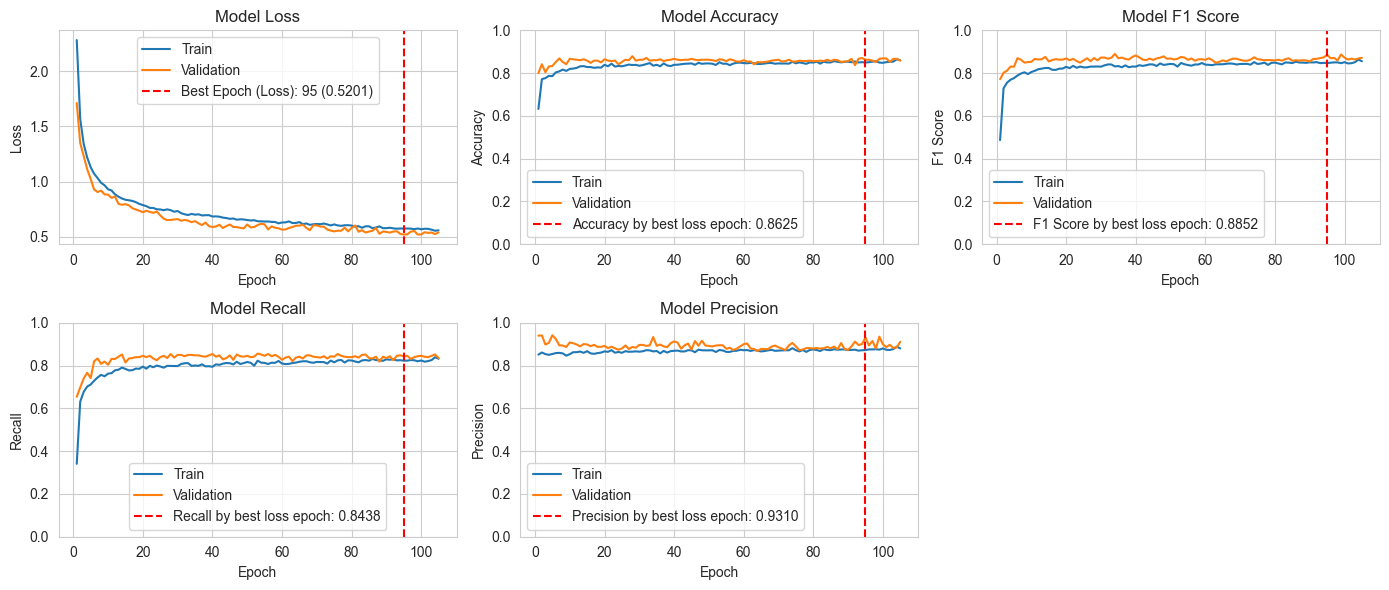

14/14 [==============================] - 3s 4ms/step - loss: 0.7210 - recall: 0.7512 - precision: 0.8753 - accuracy: 0.8093 - f1_score: 0.8085

=== Evaluation Metrics ===
loss: 0.7210
recall: 75.12%
precision: 87.53%
accuracy: 80.93%
f1_score: 80.85%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


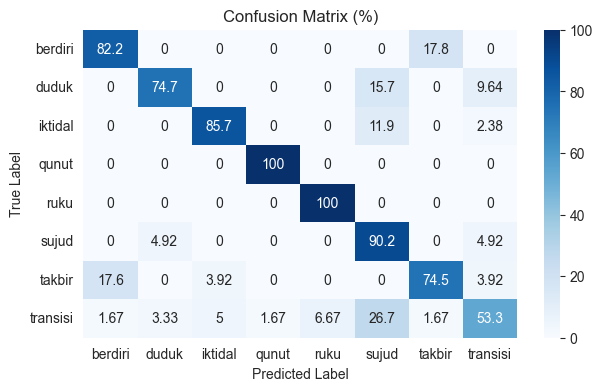


=== Done! ===


In [58]:
model_0_path_10ws = start_train(
    model=model_0_10ws,
    X_train=X_train_10,
    Y_train=Y_train_10,
    X_test=X_test_10,
    Y_test=Y_test_10,
    X_val=X_val_10,
    Y_val=Y_val_10,
    use_cache=True,
    epochs=1000,
    batch_size=32,
)

In [60]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_0_10ws_name),
    window_size=10,
)

#### 20ws


In [61]:
model_0_20ws_name = "model_0_myria-20ws"

model_0_20ws = create_model_0(
    model_name=model_0_20ws_name,
    window_size=20,
)

model_0_20ws.summary()

model_0_20ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_0_myria-20ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128)               34816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 35848 (140.03 KB)
Trainable params: 35848 (140.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 86


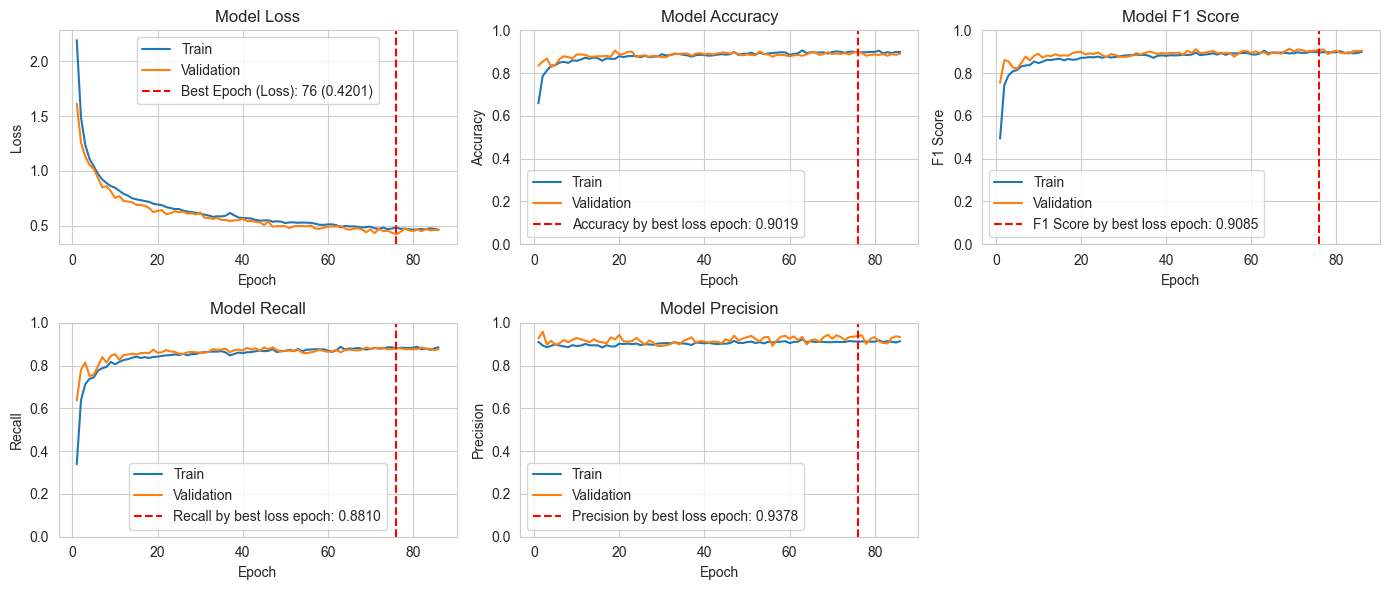

14/14 [==============================] - 3s 5ms/step - loss: 0.5806 - recall: 0.7974 - precision: 0.8954 - accuracy: 0.8811 - f1_score: 0.8436

=== Evaluation Metrics ===
loss: 0.5806
recall: 79.74%
precision: 89.54%
accuracy: 88.11%
f1_score: 84.36%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


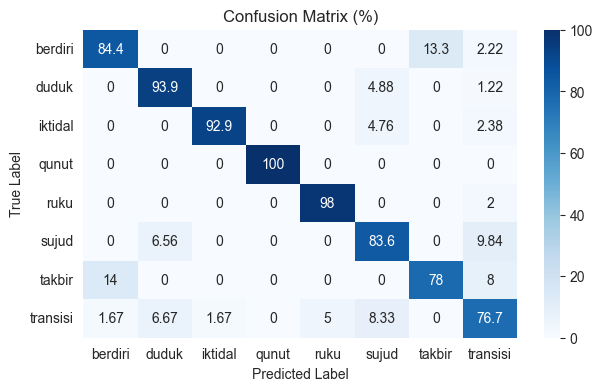


=== Done! ===


In [62]:
model_0_path_20ws = start_train(
    model=model_0_20ws,
    X_train=X_train_20,
    Y_train=Y_train_20,
    X_test=X_test_20,
    Y_test=Y_test_20,
    X_val=X_val_20,
    Y_val=Y_val_20,
    use_cache=True,
    epochs=1000,
)

In [63]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_0_20ws_name),
    window_size=20,
)

#### 30ws


In [64]:
model_0_30ws_name = "model_0_myria-30ws"

model_0_30ws = create_model_0(
    model_name=model_0_30ws_name,
    window_size=30,
)

model_0_30ws.summary()

model_0_30ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_0_myria-30ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               34816     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 35848 (140.03 KB)
Trainable params: 35848 (140.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 75


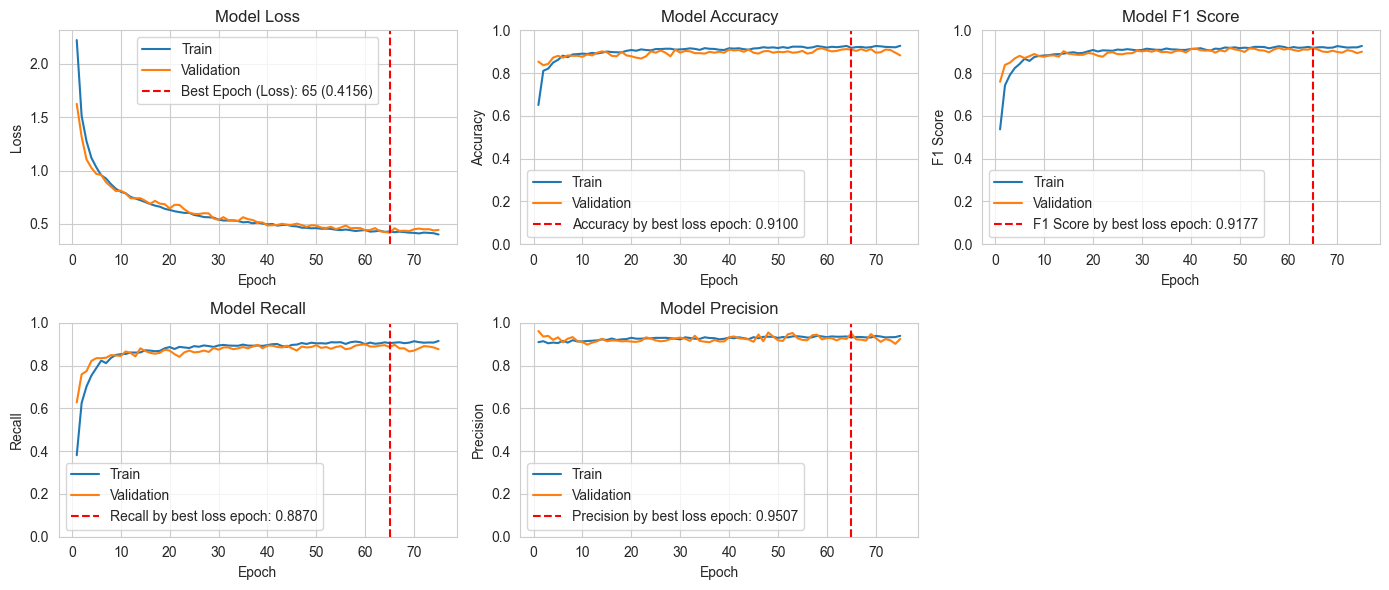

14/14 [==============================] - 3s 6ms/step - loss: 0.5152 - recall: 0.8221 - precision: 0.8997 - accuracy: 0.8855 - f1_score: 0.8591

=== Evaluation Metrics ===
loss: 0.5152
recall: 82.21%
precision: 89.97%
accuracy: 88.55%
f1_score: 85.91%

=== Confusion Matrix ===
14/14 [==============================] - 1s 5ms/step


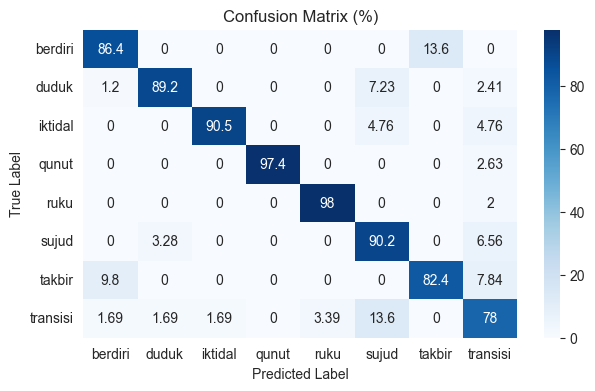


=== Done! ===


In [65]:
model_0_path_30ws = start_train(
    model=model_0_30ws,
    X_train=X_train_30,
    Y_train=Y_train_30,
    X_test=X_test_30,
    Y_test=Y_test_30,
    X_val=X_val_30,
    Y_val=Y_val_30,
    use_cache=True,
    epochs=1000,
)

In [66]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_0_30ws_name),
    window_size=30,
)

#### 40ws


In [67]:
model_0_40ws_name = "model_0_myria-40ws"

model_0_40ws = create_model_0(
    model_name=model_0_40ws_name,
    window_size=40,
)

model_0_40ws.summary()

model_0_40ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_0_myria-40ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128)               34816     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 35848 (140.03 KB)
Trainable params: 35848 (140.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 52


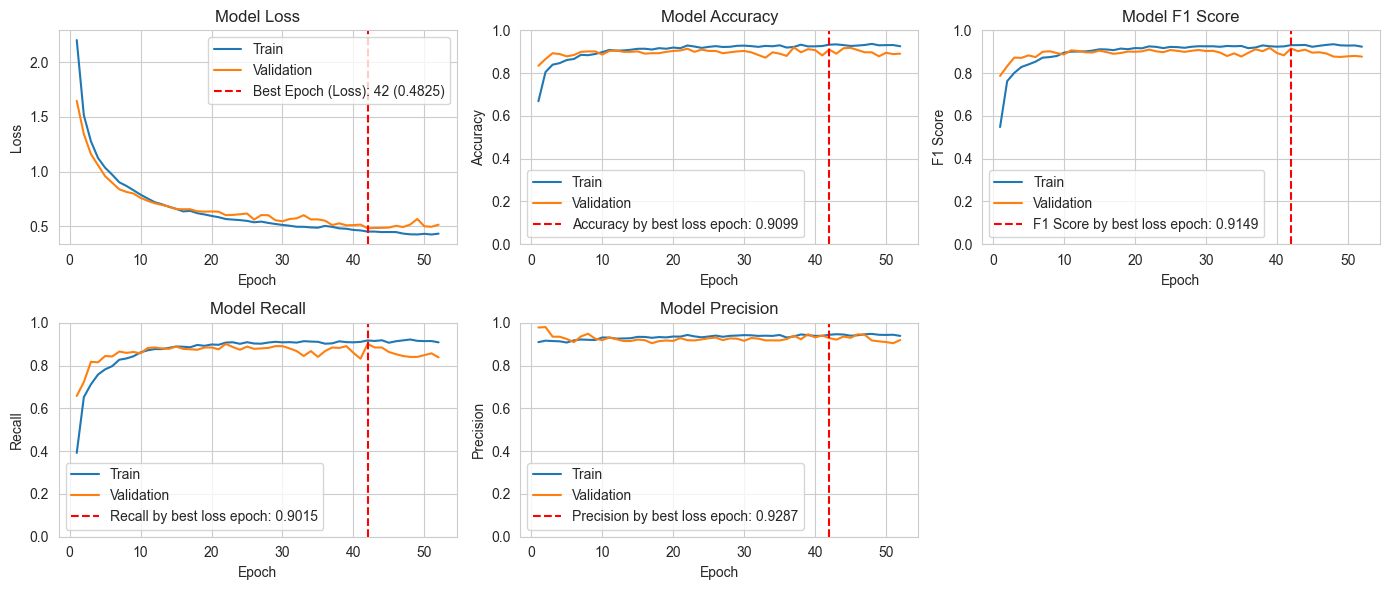

14/14 [==============================] - 3s 6ms/step - loss: 0.5503 - recall: 0.8448 - precision: 0.9113 - accuracy: 0.9297 - f1_score: 0.8768

=== Evaluation Metrics ===
loss: 0.5503
recall: 84.48%
precision: 91.13%
accuracy: 92.97%
f1_score: 87.68%

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


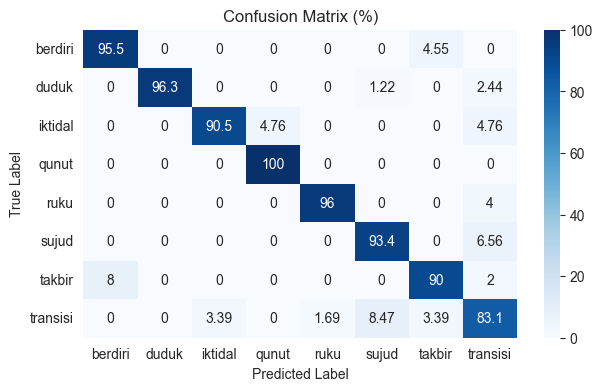


=== Done! ===


In [68]:
model_0_path_40ws = start_train(
    model=model_0_40ws,
    X_train=X_train_40,
    Y_train=Y_train_40,
    X_test=X_test_40,
    Y_test=Y_test_40,
    X_val=X_val_40,
    Y_val=Y_val_40,
    use_cache=True,
    epochs=1000,
)

In [69]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_0_40ws_name),
    window_size=40,
)

### Model 1 (LSTM) - Peta


#### Configuration


In [70]:
def create_model_1(model_name, window_size, n_hidden=64):
    input_dim = 3
    pv = 0.2

    return keras.Sequential(
        name=model_name,
        layers=[
            layers.LSTM(
                n_hidden,
                return_sequences=True,
                input_shape=(window_size, input_dim),
                kernel_regularizer=keras.regularizers.l2(1e-5),
            ),
            layers.Dropout(pv),
            layers.LSTM(int(n_hidden / 2)),
            layers.Dropout(pv),
            layers.Dense(n_classes, activation="softmax"),
        ],
    )

#### 10ws


In [71]:
model_1_10ws_name = "model_1_peta-10ws"

model_1_10ws = create_model_1(
    model_name=model_1_10ws_name,
    window_size=10,
)

model_1_10ws.summary()

model_1_10ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_1_peta-10ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 64)            17408     
                                                                 
 dropout_4 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
Total params: 30088 (117.53 KB)
Trainable params: 30088 (117.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 23


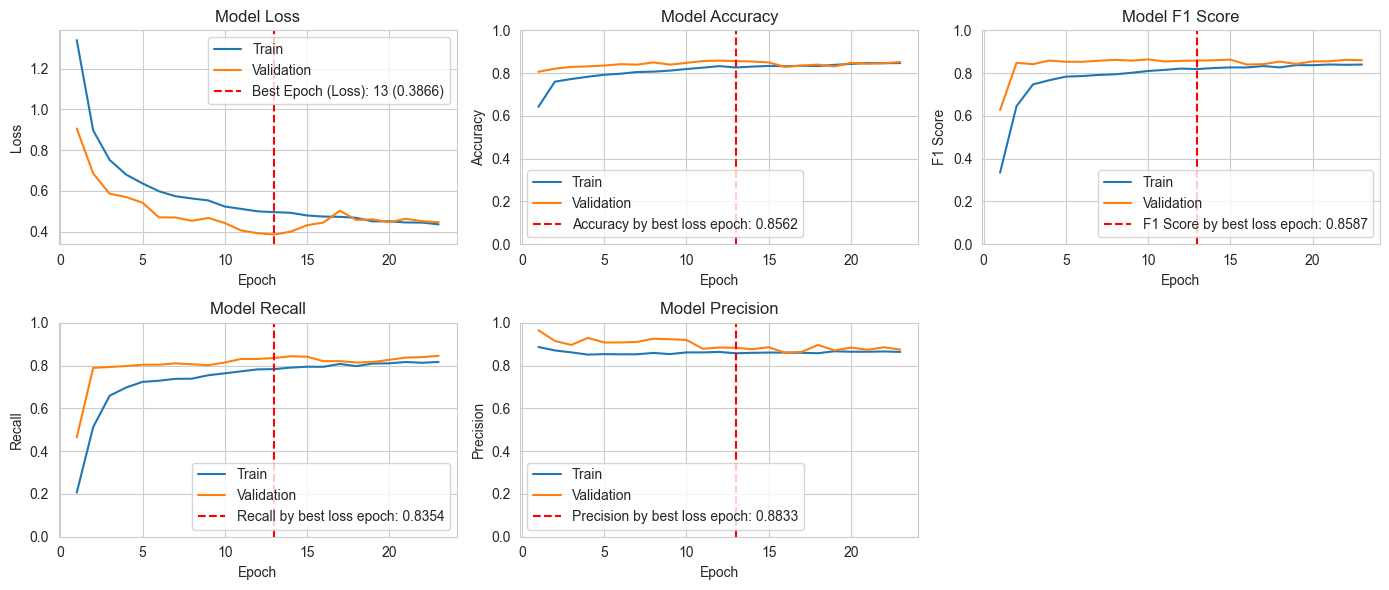

14/14 [==============================] - 3s 4ms/step - loss: 0.5730 - recall: 0.8218 - precision: 0.8940 - accuracy: 0.7814 - f1_score: 0.8564

=== Evaluation Metrics ===
loss: 0.5730
recall: 82.18%
precision: 89.40%
accuracy: 78.14%
f1_score: 85.64%

=== Confusion Matrix ===
14/14 [==============================] - 1s 4ms/step


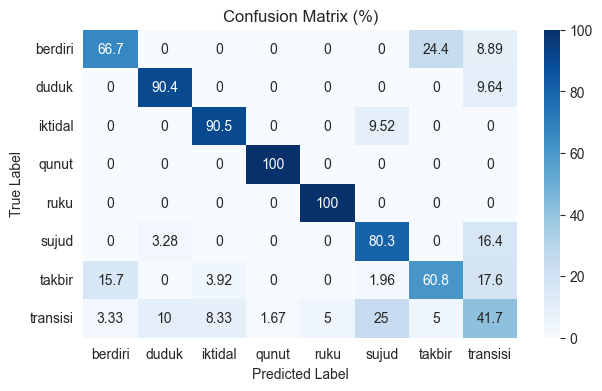


=== Done! ===


In [72]:
model_1_path_10ws = start_train(
    model=model_1_10ws,
    X_train=X_train_10,
    Y_train=Y_train_10,
    X_test=X_test_10,
    Y_test=Y_test_10,
    X_val=X_val_10,
    Y_val=Y_val_10,
    use_cache=True,
    epochs=1000,
)

In [73]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_1_10ws_name),
    window_size=10,
)

#### 20ws


In [74]:
model_1_20ws_name = "model_1_peta-20ws"

model_1_20ws = create_model_1(
    model_name=model_1_20ws_name,
    window_size=20,
)

model_1_20ws.summary()

model_1_20ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_1_peta-20ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 64)            17408     
                                                                 
 dropout_6 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 30088 (117.53 KB)
Trainable params: 30088 (117.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 25


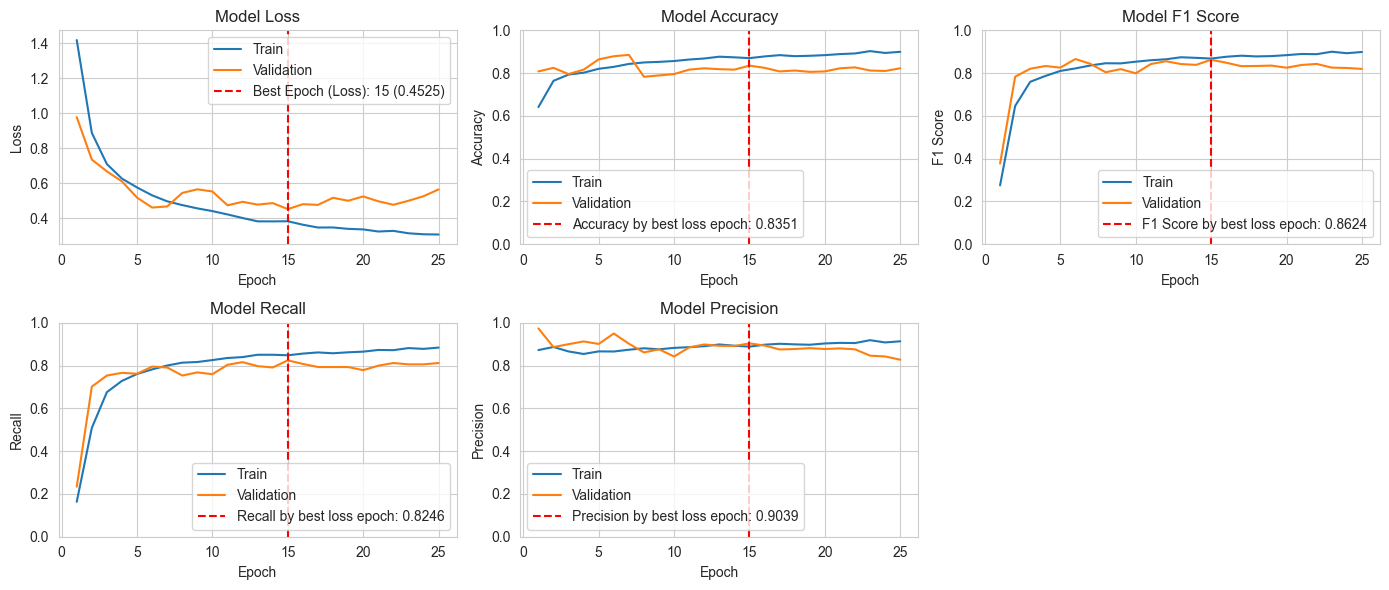

14/14 [==============================] - 3s 7ms/step - loss: 0.5016 - recall: 0.8212 - precision: 0.8893 - accuracy: 0.8322 - f1_score: 0.8539

=== Evaluation Metrics ===
loss: 0.5016
recall: 82.12%
precision: 88.93%
accuracy: 83.22%
f1_score: 85.39%

=== Confusion Matrix ===
14/14 [==============================] - 1s 5ms/step


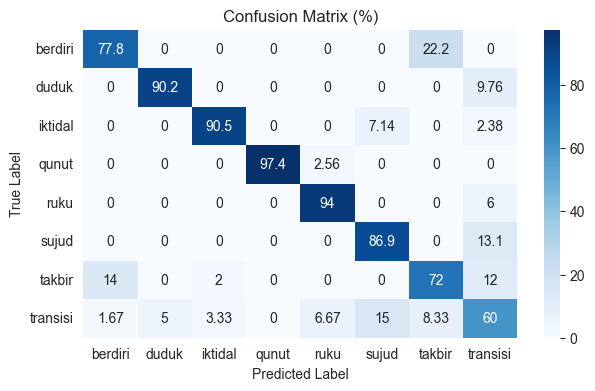


=== Done! ===


In [75]:
model_1_path_20ws = start_train(
    model=model_1_20ws,
    X_train=X_train_20,
    Y_train=Y_train_20,
    X_test=X_test_20,
    Y_test=Y_test_20,
    X_val=X_val_20,
    Y_val=Y_val_20,
    use_cache=True,
    epochs=1000,
)

In [76]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_1_20ws_name),
    window_size=20,
)

#### 30ws


In [77]:
model_1_30ws_name = "model_1_peta-30ws"

model_1_30ws = create_model_1(
    model_name=model_1_30ws_name,
    window_size=30,
)

model_1_30ws.summary()

model_1_30ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_1_peta-30ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 64)            17408     
                                                                 
 dropout_8 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
Total params: 30088 (117.53 KB)
Trainable params: 30088 (117.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 26


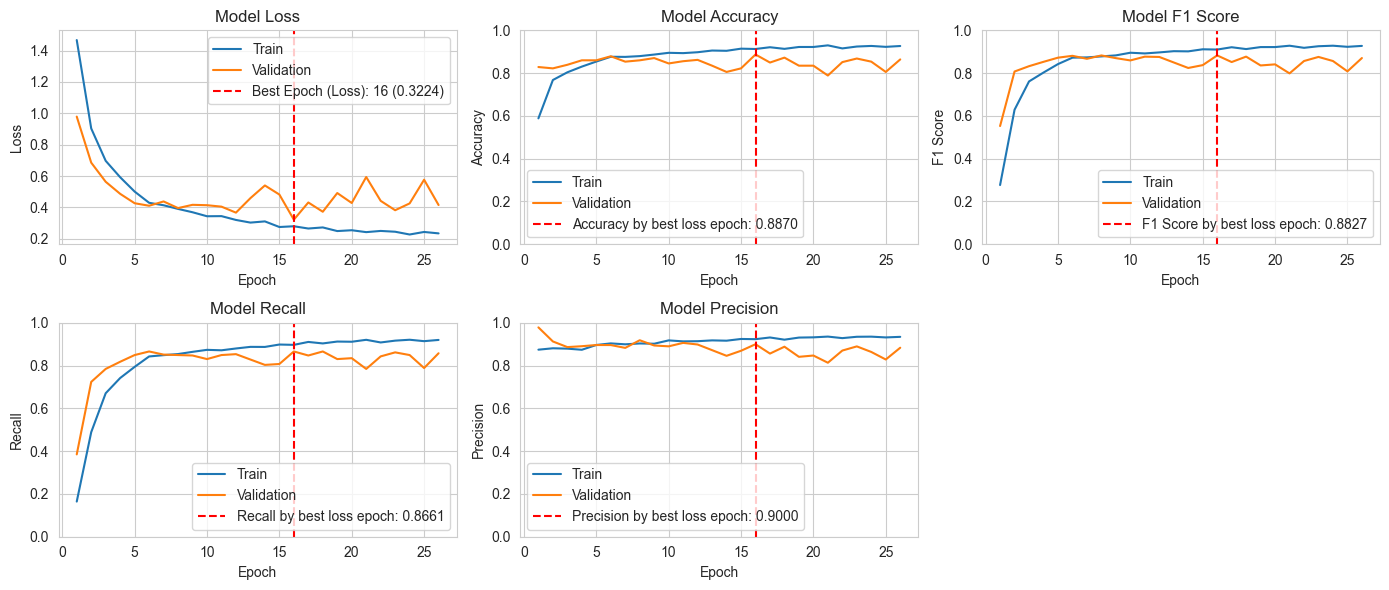

14/14 [==============================] - 3s 5ms/step - loss: 0.4839 - recall: 0.8211 - precision: 0.8838 - accuracy: 0.8388 - f1_score: 0.8513

=== Evaluation Metrics ===
loss: 0.4839
recall: 82.11%
precision: 88.38%
accuracy: 83.88%
f1_score: 85.13%

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


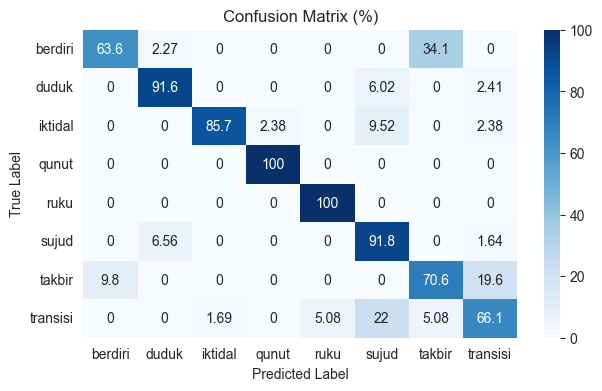


=== Done! ===


In [78]:
model_1_path_30ws = start_train(
    model=model_1_30ws,
    X_train=X_train_30,
    Y_train=Y_train_30,
    X_test=X_test_30,
    Y_test=Y_test_30,
    X_val=X_val_30,
    Y_val=Y_val_30,
    use_cache=True,
    epochs=1000,
)

In [79]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_1_30ws_name),
    window_size=30,
)

#### 40ws


In [80]:
model_1_40ws_name = "model_1_peta-40ws"

model_1_40ws = create_model_1(
    model_name=model_1_40ws_name,
    window_size=40,
)

model_1_40ws.summary()

model_1_40ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_1_peta-40ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 40, 64)            17408     
                                                                 
 dropout_10 (Dropout)        (None, 40, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
Total params: 30088 (117.53 KB)
Trainable params: 30088 (117.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 42


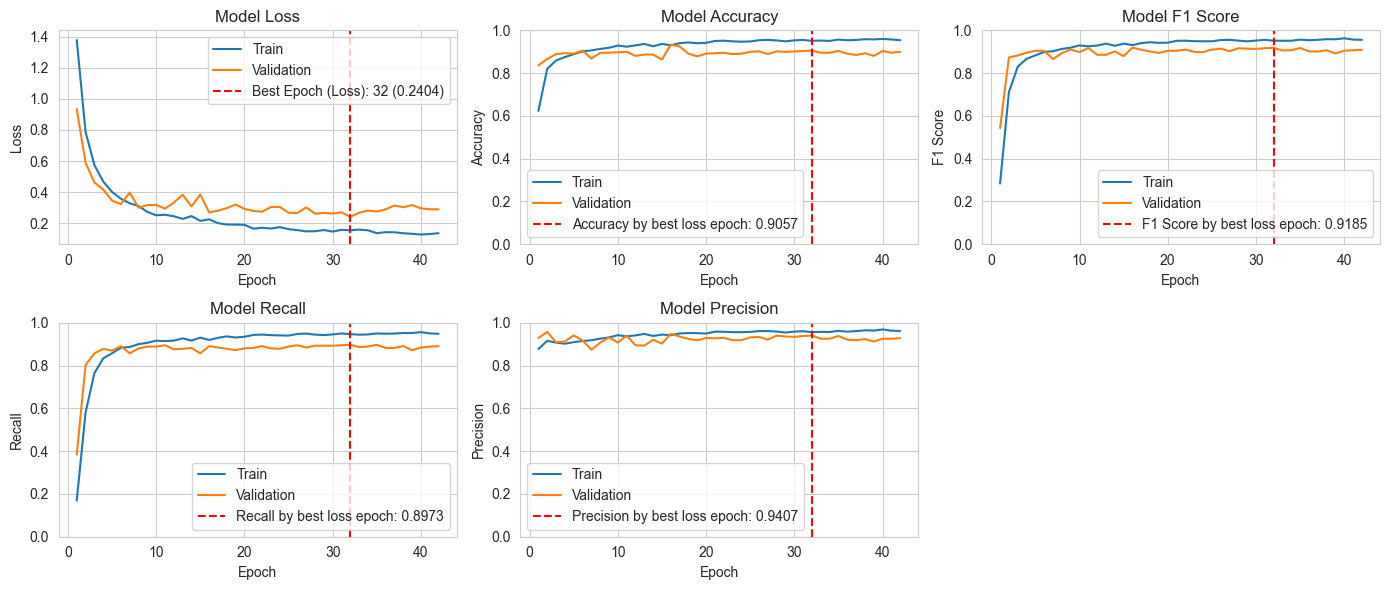

14/14 [==============================] - 3s 7ms/step - loss: 0.3799 - recall: 0.8291 - precision: 0.8873 - accuracy: 0.8970 - f1_score: 0.8572

=== Evaluation Metrics ===
loss: 0.3799
recall: 82.91%
precision: 88.73%
accuracy: 89.70%
f1_score: 85.72%

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


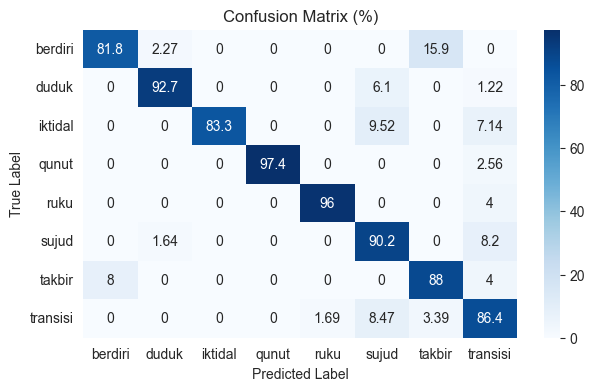


=== Done! ===


In [81]:
model_1_path_40ws = start_train(
    model=model_1_40ws,
    X_train=X_train_40,
    Y_train=Y_train_40,
    X_test=X_test_40,
    Y_test=Y_test_40,
    X_val=X_val_40,
    Y_val=Y_val_40,
    use_cache=True,
    epochs=1000,
)

In [82]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_1_40ws_name),
    window_size=40,
)

### Model 2 (GRU) - Zetta


#### Configuration


In [83]:
def create_model_2(model_name, window_size, n_hidden=64):
    input_dim = 3
    pv = 0.2

    model = keras.Sequential(
        name=model_name,
        layers=[
            layers.GRU(
                n_hidden,
                return_sequences=True,
                input_shape=(window_size, input_dim),
                kernel_regularizer=keras.regularizers.l2(1e-5),
            ),
            layers.Dropout(pv),
            layers.GRU(int(n_hidden / 2)),
            layers.Dropout(pv),
            layers.Dense(n_classes, activation="softmax"),
        ],
    )

    return model

#### 10ws


In [84]:
model_2_10ws_name = "model_2_zetta-10ws"

model_2_10ws = create_model_2(
    model_name=model_2_10ws_name,
    window_size=10,
)

model_2_10ws.summary()

model_2_10ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_2_zetta-10ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            13248     
                                                                 
 dropout_12 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
Total params: 22920 (89.53 KB)
Trainable params: 22920 (89.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 19


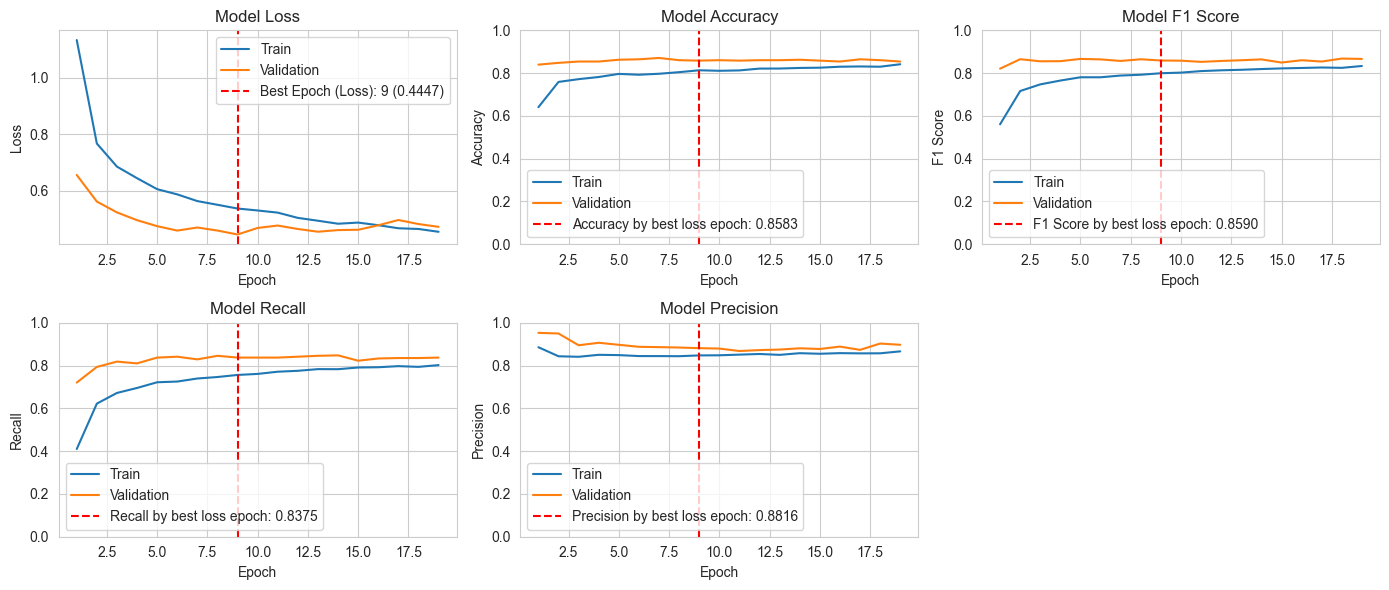

14/14 [==============================] - 4s 3ms/step - loss: 0.6011 - recall: 0.8154 - precision: 0.8785 - accuracy: 0.7605 - f1_score: 0.8458

=== Evaluation Metrics ===
loss: 0.6011
recall: 81.54%
precision: 87.85%
accuracy: 76.05%
f1_score: 84.58%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


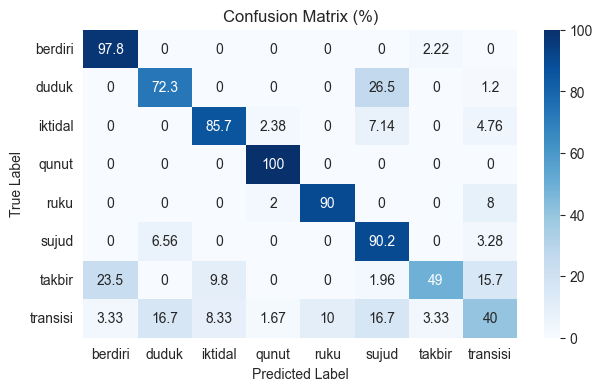


=== Done! ===


In [85]:
model_2_path_10ws = start_train(
    model=model_2_10ws,
    X_train=X_train_10,
    Y_train=Y_train_10,
    X_test=X_test_10,
    Y_test=Y_test_10,
    X_val=X_val_10,
    Y_val=Y_val_10,
    use_cache=True,
    epochs=1000,
)

In [86]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_2_10ws_name),
    window_size=10,
)

#### 20ws


In [87]:
model_2_20ws_name = "model_2_zetta-20ws"

model_2_20ws = create_model_2(
    model_name=model_2_20ws_name,
    window_size=20,
)

model_2_20ws.summary()

model_2_20ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_2_zetta-20ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 20, 64)            13248     
                                                                 
 dropout_14 (Dropout)        (None, 20, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
Total params: 22920 (89.53 KB)
Trainable params: 22920 (89.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 43


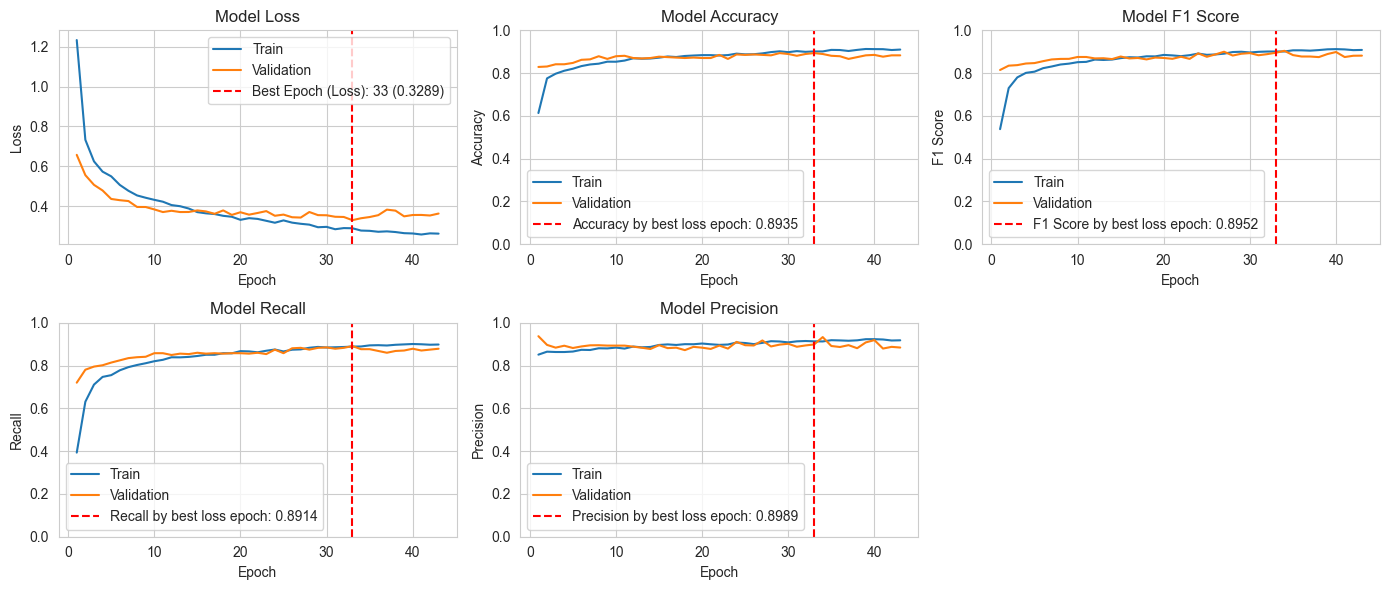

14/14 [==============================] - 3s 5ms/step - loss: 0.4249 - recall: 0.8176 - precision: 0.8780 - accuracy: 0.8648 - f1_score: 0.8467

=== Evaluation Metrics ===
loss: 0.4249
recall: 81.76%
precision: 87.80%
accuracy: 86.48%
f1_score: 84.67%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


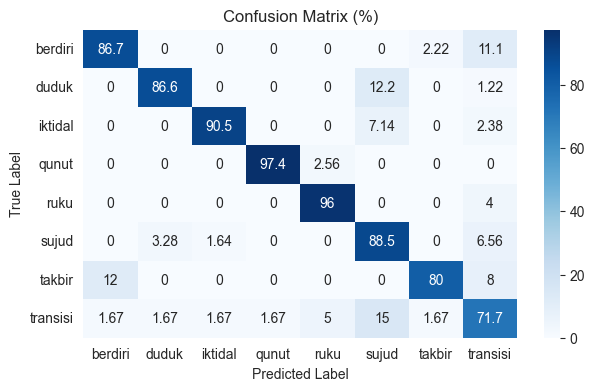


=== Done! ===


In [88]:
model_2_path_20ws = start_train(
    model=model_2_20ws,
    X_train=X_train_20,
    Y_train=Y_train_20,
    X_test=X_test_20,
    Y_test=Y_test_20,
    X_val=X_val_20,
    Y_val=Y_val_20,
    use_cache=True,
    epochs=1000,
)

In [89]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_2_20ws_name),
    window_size=20,
)

#### 30ws


In [90]:
model_2_30ws_name = "model_2_zetta-30ws"

model_2_30ws = create_model_2(
    model_name=model_2_30ws_name,
    window_size=30,
)

model_2_30ws.summary()

model_2_30ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_2_zetta-30ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 30, 64)            13248     
                                                                 
 dropout_16 (Dropout)        (None, 30, 64)            0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
Total params: 22920 (89.53 KB)
Trainable params: 22920 (89.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 30


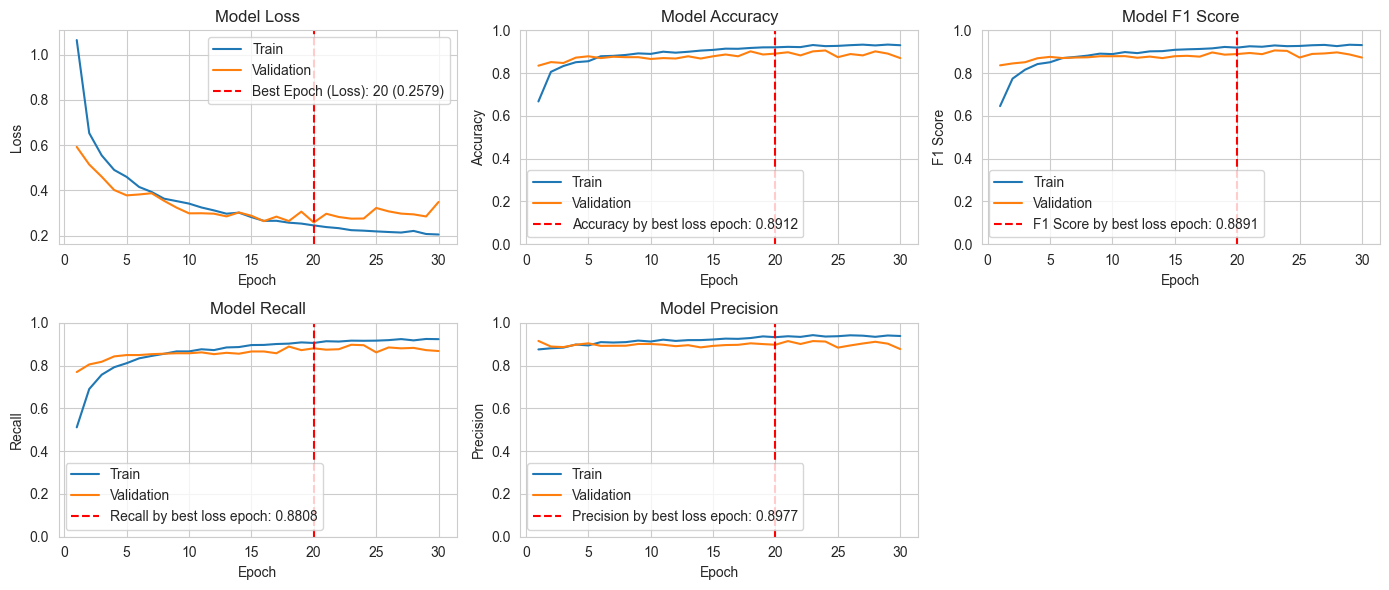

14/14 [==============================] - 3s 6ms/step - loss: 0.3925 - recall: 0.8204 - precision: 0.8781 - accuracy: 0.8621 - f1_score: 0.8482

=== Evaluation Metrics ===
loss: 0.3925
recall: 82.04%
precision: 87.81%
accuracy: 86.21%
f1_score: 84.82%

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


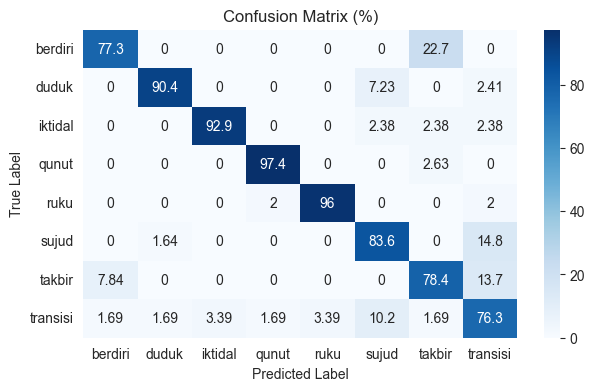


=== Done! ===


In [91]:
model_2_30ws_name = "model_2_zetta-30ws"
model_2_path_30ws = start_train(
    model=model_2_30ws,
    X_train=X_train_30,
    Y_train=Y_train_30,
    X_test=X_test_30,
    Y_test=Y_test_30,
    X_val=X_val_30,
    Y_val=Y_val_30,
    use_cache=True,
    epochs=1000,
)

In [92]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_2_30ws_name),
    window_size=30,
)

#### 40ws


In [93]:
model_2_40ws_name = "model_2_zetta-40ws"

model_2_40ws = create_model_2(
    model_name=model_2_40ws_name,
    window_size=40,
)

model_2_40ws.summary()

model_2_40ws.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    metrics=[recall, precision, "accuracy", f1],
)

Model: "model_2_zetta-40ws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 40, 64)            13248     
                                                                 
 dropout_18 (Dropout)        (None, 40, 64)            0         
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
Total params: 22920 (89.53 KB)
Trainable params: 22920 (89.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Total epochs: 31


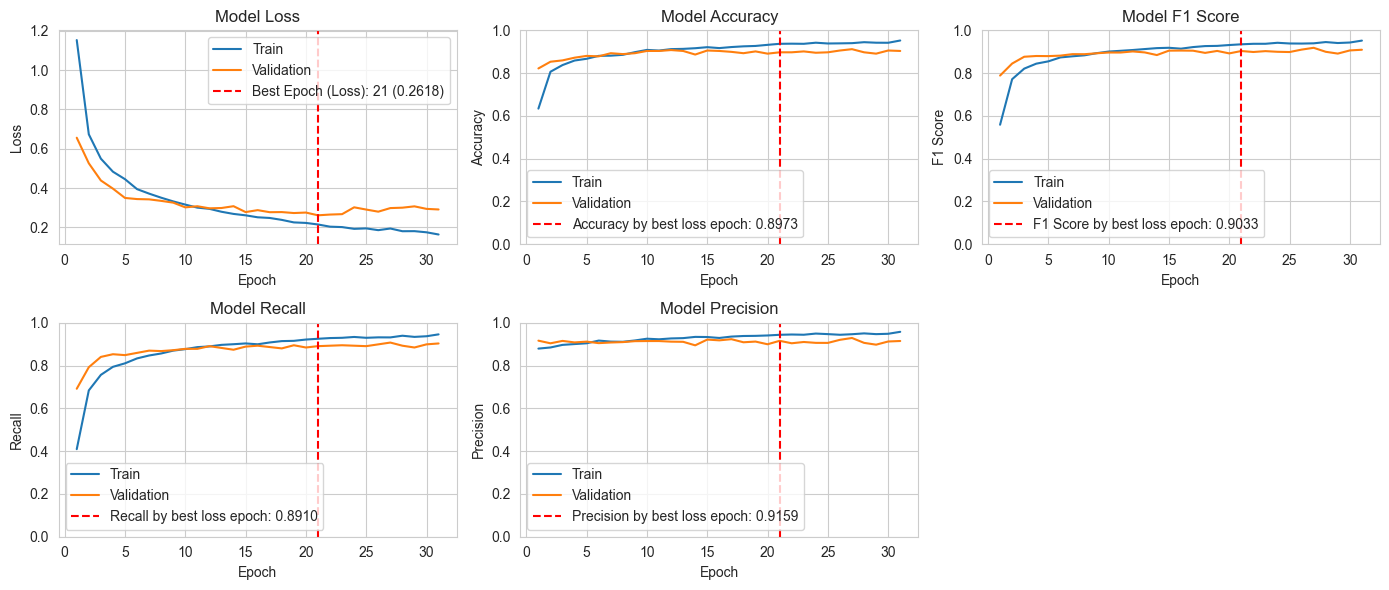

14/14 [==============================] - 3s 9ms/step - loss: 0.3240 - recall: 0.8269 - precision: 0.8812 - accuracy: 0.9087 - f1_score: 0.8532

=== Evaluation Metrics ===
loss: 0.3240
recall: 82.69%
precision: 88.12%
accuracy: 90.87%
f1_score: 85.32%

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


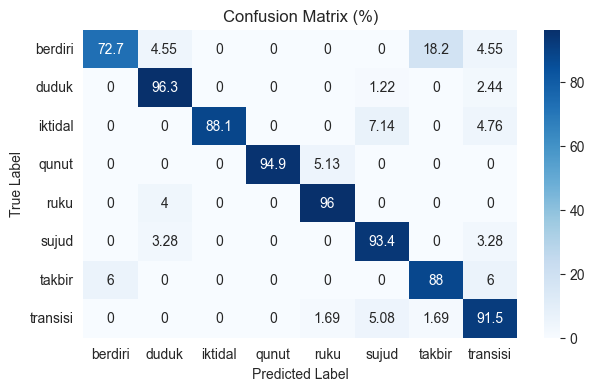


=== Done! ===


In [94]:
model_2_path_40ws = start_train(
    model=model_2_40ws,
    X_train=X_train_40,
    Y_train=Y_train_40,
    X_test=X_test_40,
    Y_test=Y_test_40,
    X_val=X_val_40,
    Y_val=Y_val_40,
    use_cache=True,
    epochs=1000,
)

In [95]:
upload_to_firebase(
    directory_path=os.path.join(models_directory, model_2_40ws_name),
    window_size=40,
)

## Model Playground


In [ ]:
model = keras.models.load_model("models/model_2_zetta-10ws/model.keras")
df0 = val_df[val_df["movement_set_id"] == "bd3325e5-9156-4e39-a67b-80870385b5e2"]
x, y = create_segments_and_labels(
    df0,
    10,
    10,
    "label_category",
    one_hot_encoder,
)

[
    LABEL_CATEGORIES[y]
    for y in np.argmax(
        model.predict(x),
        axis=1,
    )
]

In [ ]:
!unzip models.zip

In [ ]:
!zip -r models.zip models

### Adagrad

In [58]:
def evaluate_test_model_adagrad(learning_rate, batch_size, hidden_layer=64, show_summary=False, use_cache=False):
    model_name = (
        f"test2-model_0_myria-20ws-adagrad-{learning_rate}lr-{batch_size}bs-{hidden_layer}hl"
    )

    model = create_model_0(
        model_name=model_name,
        window_size=20,
        n_hidden=hidden_layer,
    )

    if show_summary:
        model.summary()

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate),
        metrics=[recall, precision, "accuracy", f1],
    )

    model_path = start_train(
        model=model,
        X_train=X_train_20,
        Y_train=Y_train_20,
        X_test=X_test_20,
        Y_test=Y_test_20,
        X_val=X_val_20,
        Y_val=Y_val_20,
        use_cache=use_cache,
        epochs=1000,
        batch_size=batch_size,
        verbose=0,
    )

#### Learning Rate

##### 0.1lr

Training took 58.93 seconds
Total epochs: 61


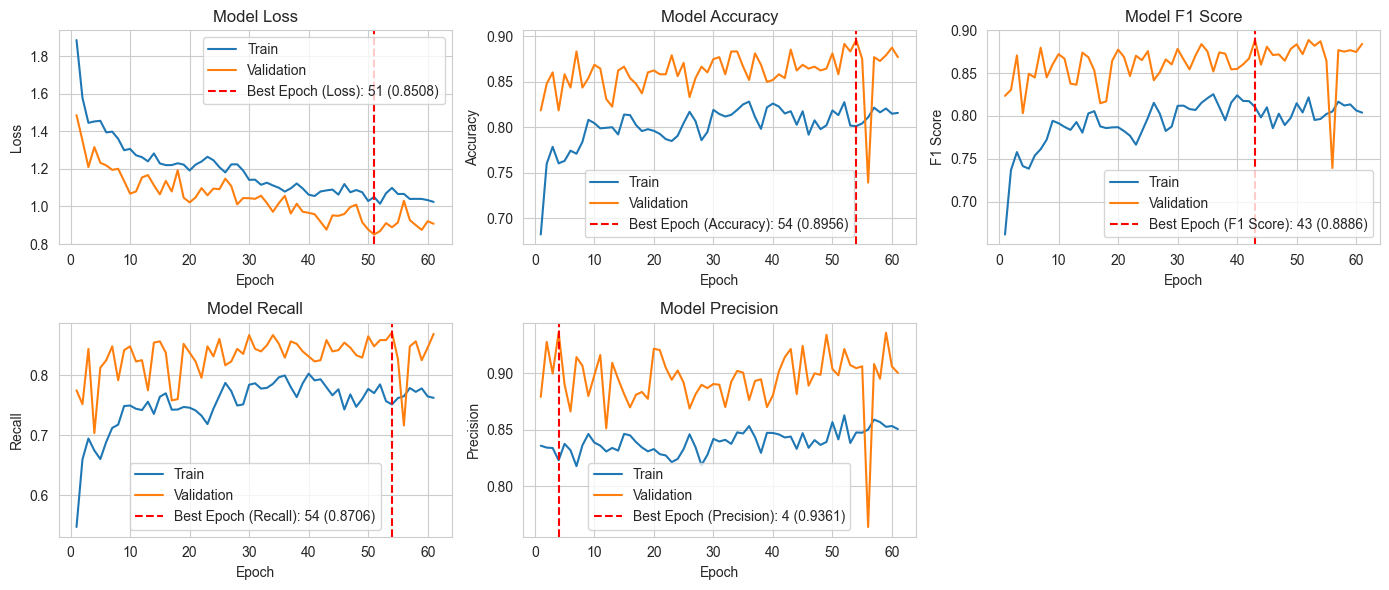

14/14 [==============================] - 0s 3ms/step - loss: 1.0278 - recall: 0.8089 - precision: 0.8697 - accuracy: 0.8392 - f1_score: 0.8382

=== Evaluation Metrics ===
loss: 1.0278
recall: 80.89%
precision: 86.97%
accuracy: 83.92%
f1_score: 83.82%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


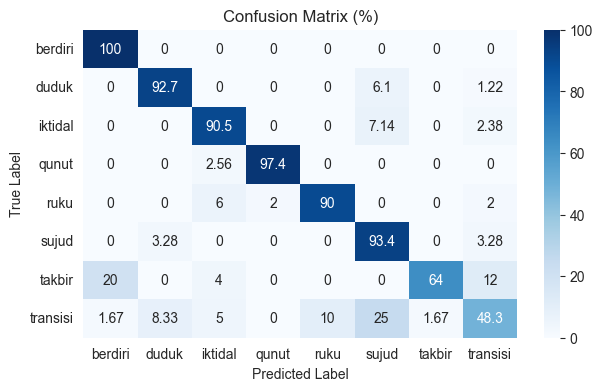


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.1lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 12:54:25.798388: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 12:54:25.798684: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 12:54:26.938892: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 12:54:26.939017: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.1lr-32bs-64hl/model.onnx

=== Done! ===


In [67]:
evaluate_test_model_adagrad(
    learning_rate=0.1,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

##### 0.01lr

Training took 57.30 seconds
Total epochs: 53


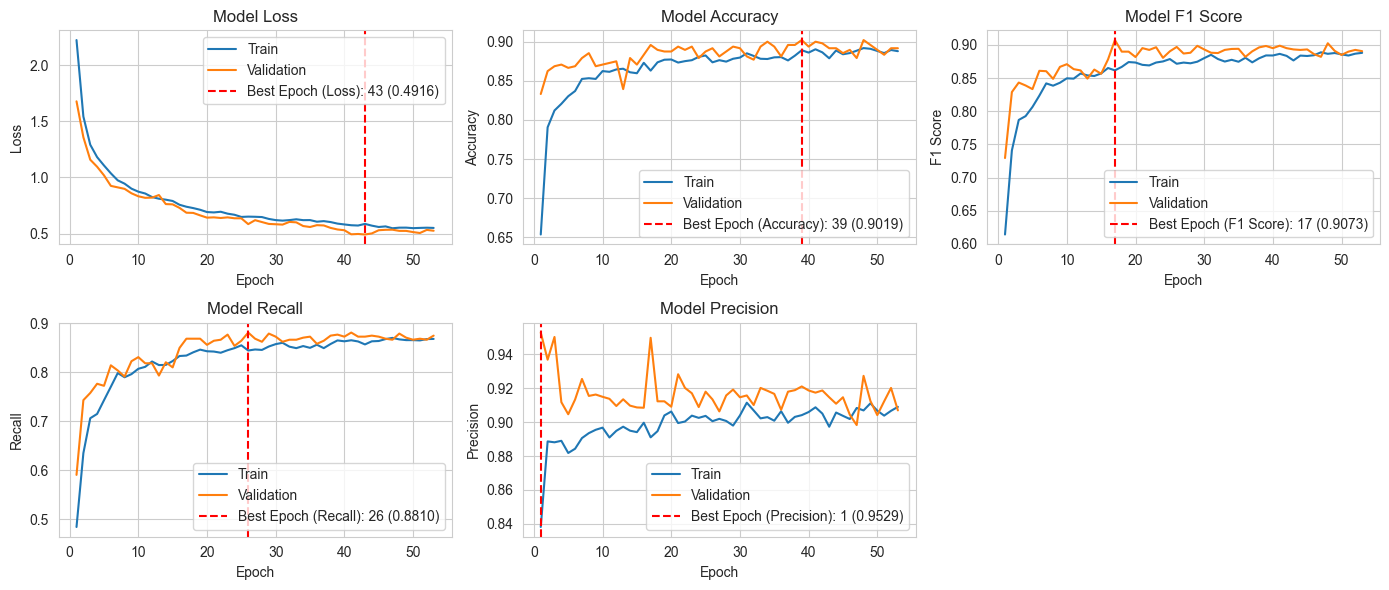

14/14 [==============================] - 0s 4ms/step - loss: 0.6328 - recall: 0.8462 - precision: 0.9007 - accuracy: 0.8741 - f1_score: 0.8726

=== Evaluation Metrics ===
loss: 0.6328
recall: 84.62%
precision: 90.07%
accuracy: 87.41%
f1_score: 87.26%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


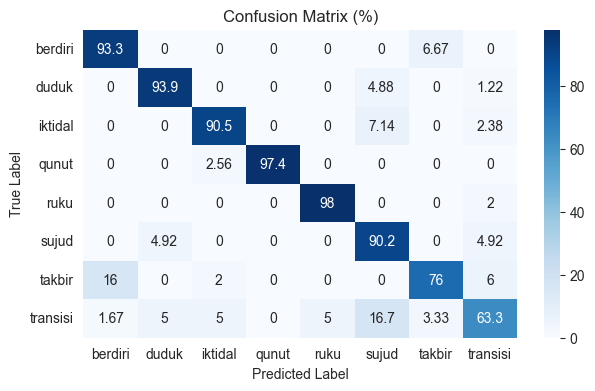


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 12:53:18.964370: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 12:53:18.964583: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 12:53:19.451838: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 12:53:19.451976: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-64hl/model.onnx

=== Done! ===


In [66]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

##### 0.001lr

Training took 368.45 seconds
Total epochs: 439


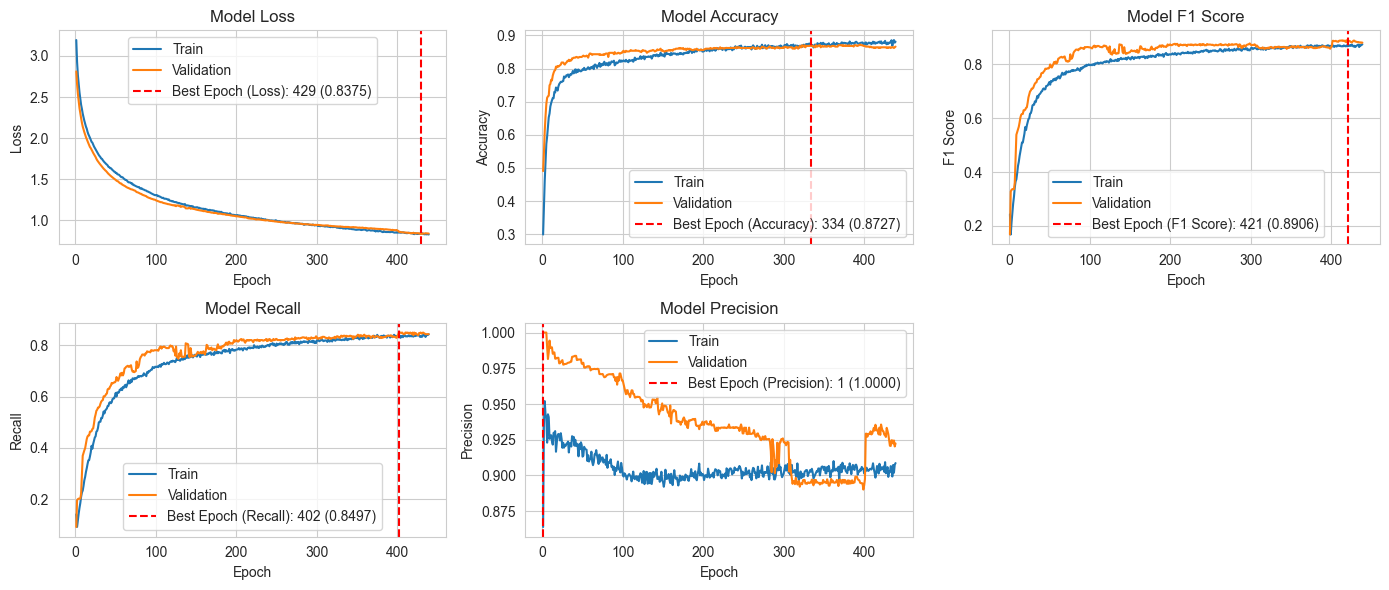

14/14 [==============================] - 0s 3ms/step - loss: 0.9626 - recall: 0.7599 - precision: 0.9132 - accuracy: 0.8345 - f1_score: 0.8295

=== Evaluation Metrics ===
loss: 0.9626
recall: 75.99%
precision: 91.32%
accuracy: 83.45%
f1_score: 82.95%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


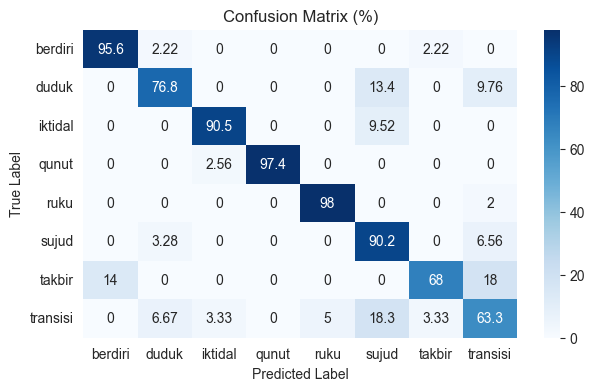


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.001lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 13:03:36.305002: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 13:03:36.305186: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 13:03:36.703831: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 13:03:36.703967: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.001lr-32bs-64hl/model.onnx

=== Done! ===


In [68]:
evaluate_test_model_adagrad(
    learning_rate=0.001,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

##### 0.0001lr

Training took 951.32 seconds
Total epochs: 1000


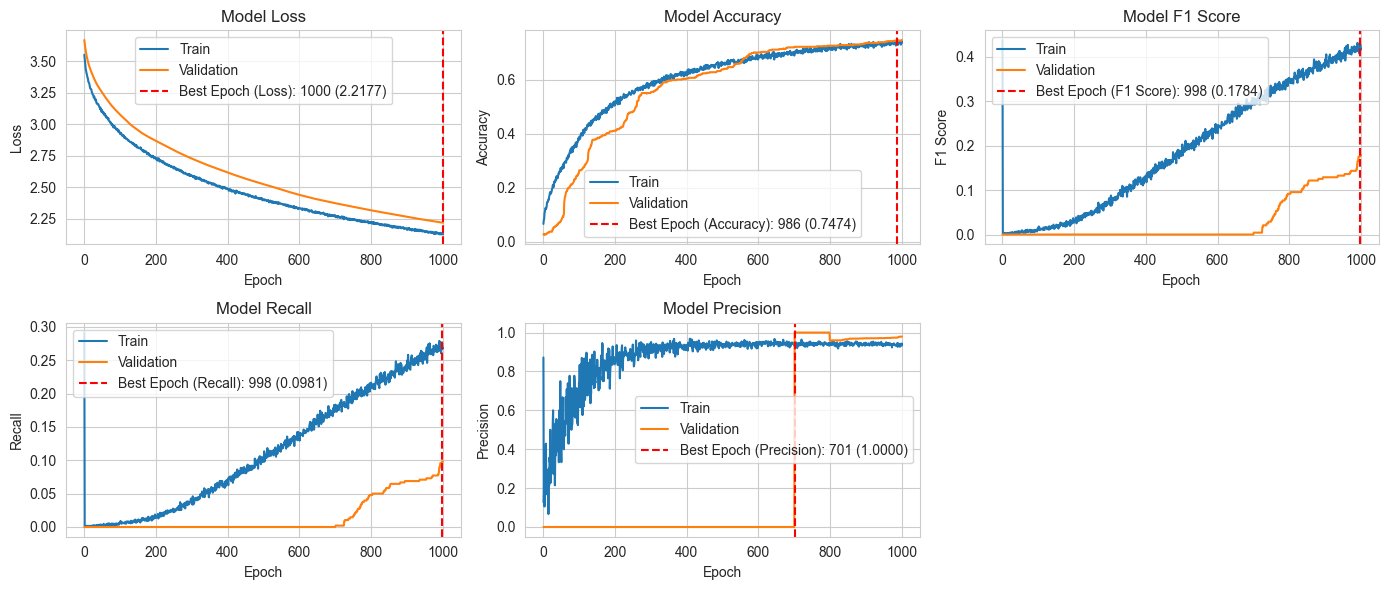

14/14 [==============================] - 0s 7ms/step - loss: 2.2297 - recall: 0.1469 - precision: 0.9545 - accuracy: 0.7459 - f1_score: 0.2545

=== Evaluation Metrics ===
loss: 2.2297
recall: 14.69%
precision: 95.45%
accuracy: 74.59%
f1_score: 25.45%

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


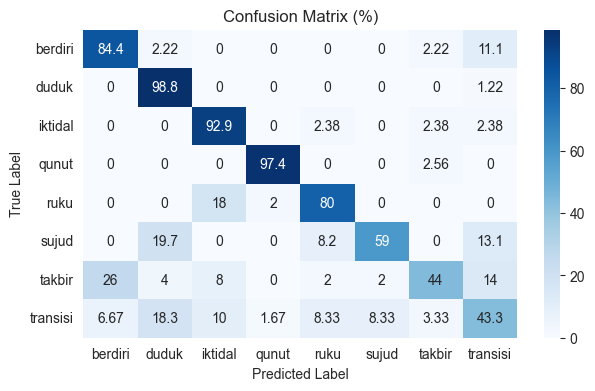


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.0001lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 09:42:39.542709: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:42:39.542877: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 09:42:40.101785: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:42:40.101948: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.0001lr-32bs-64hl/model.onnx

=== Done! ===


In [116]:
evaluate_test_model_adagrad(
    learning_rate=0.0001,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

#### Batch Size

##### 64bs

Training took 40.25 seconds
Total epochs: 72


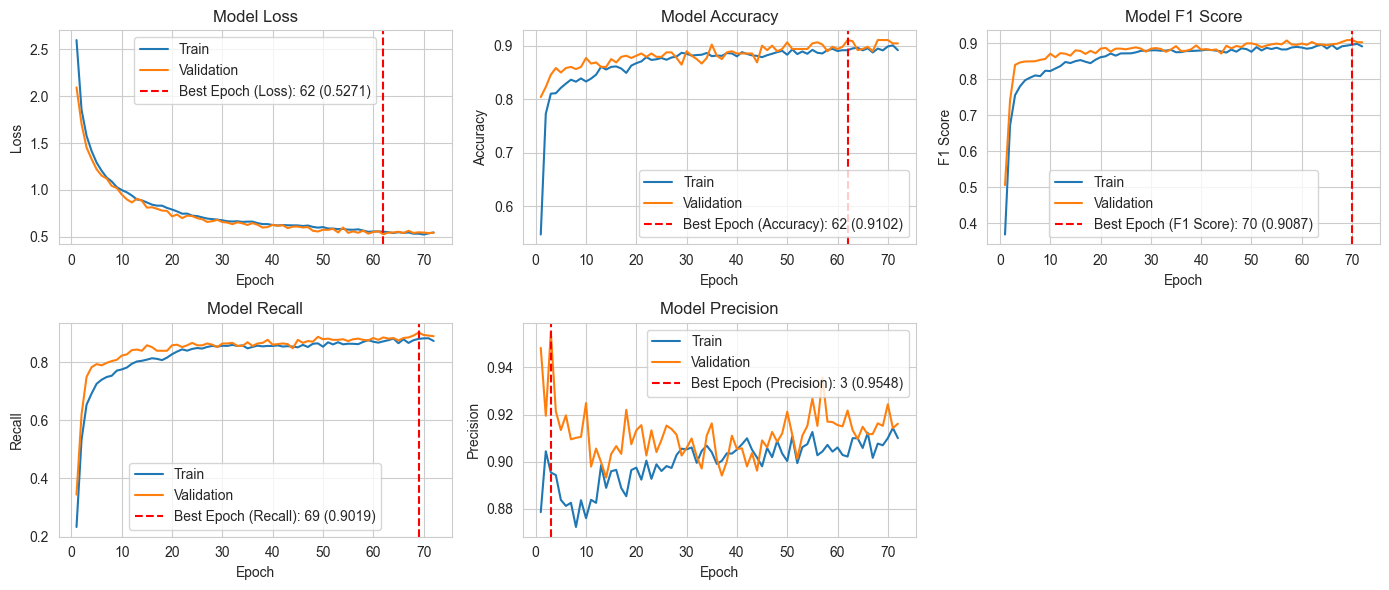

14/14 [==============================] - 0s 3ms/step - loss: 0.6462 - recall: 0.8065 - precision: 0.8918 - accuracy: 0.8788 - f1_score: 0.8470

=== Evaluation Metrics ===
loss: 0.6462
recall: 80.65%
precision: 89.18%
accuracy: 87.88%
f1_score: 84.70%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


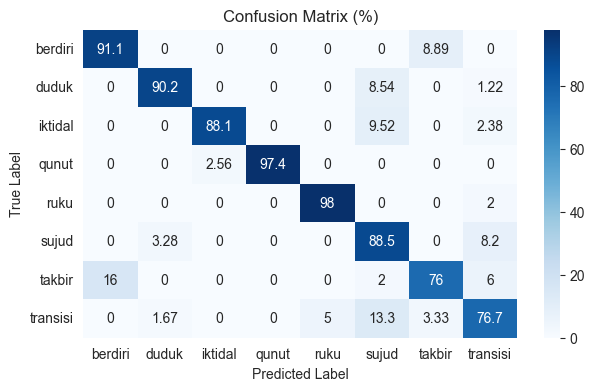


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-64bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 14:05:25.027873: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:05:25.028056: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:05:25.410329: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:05:25.410463: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-64bs-64hl/model.onnx

=== Done! ===


In [72]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=64,
    hidden_layer=64,
    use_cache=False,
)

##### 128bs

Training took 39.37 seconds
Total epochs: 86


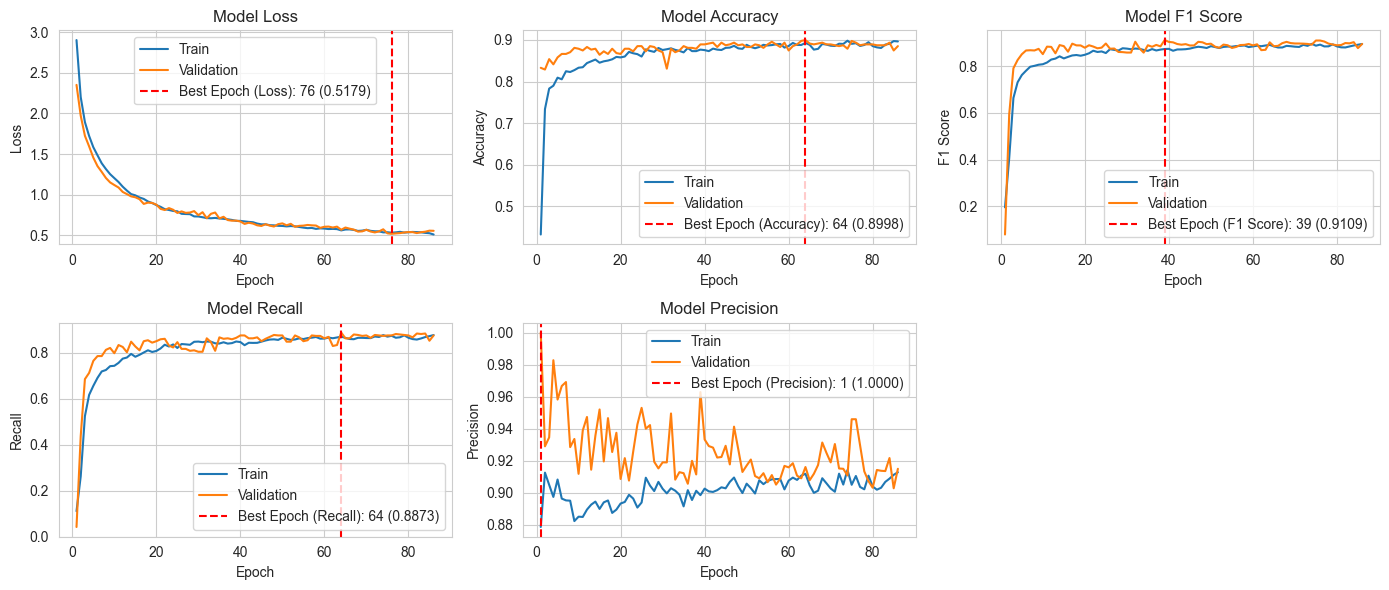

14/14 [==============================] - 0s 3ms/step - loss: 0.6718 - recall: 0.7879 - precision: 0.8942 - accuracy: 0.8648 - f1_score: 0.8377

=== Evaluation Metrics ===
loss: 0.6718
recall: 78.79%
precision: 89.42%
accuracy: 86.48%
f1_score: 83.77%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


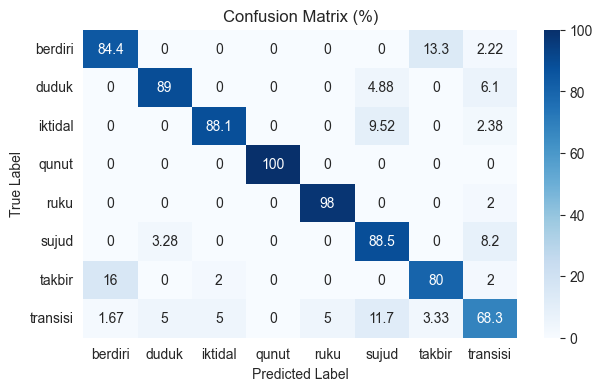


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-128bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 14:06:10.583175: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:06:10.583333: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:06:10.966380: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:06:10.966512: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-128bs-64hl/model.onnx

=== Done! ===


In [73]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=128,
    hidden_layer=64,
    use_cache=False,
)

##### 256bs

Training took 36.03 seconds
Total epochs: 92


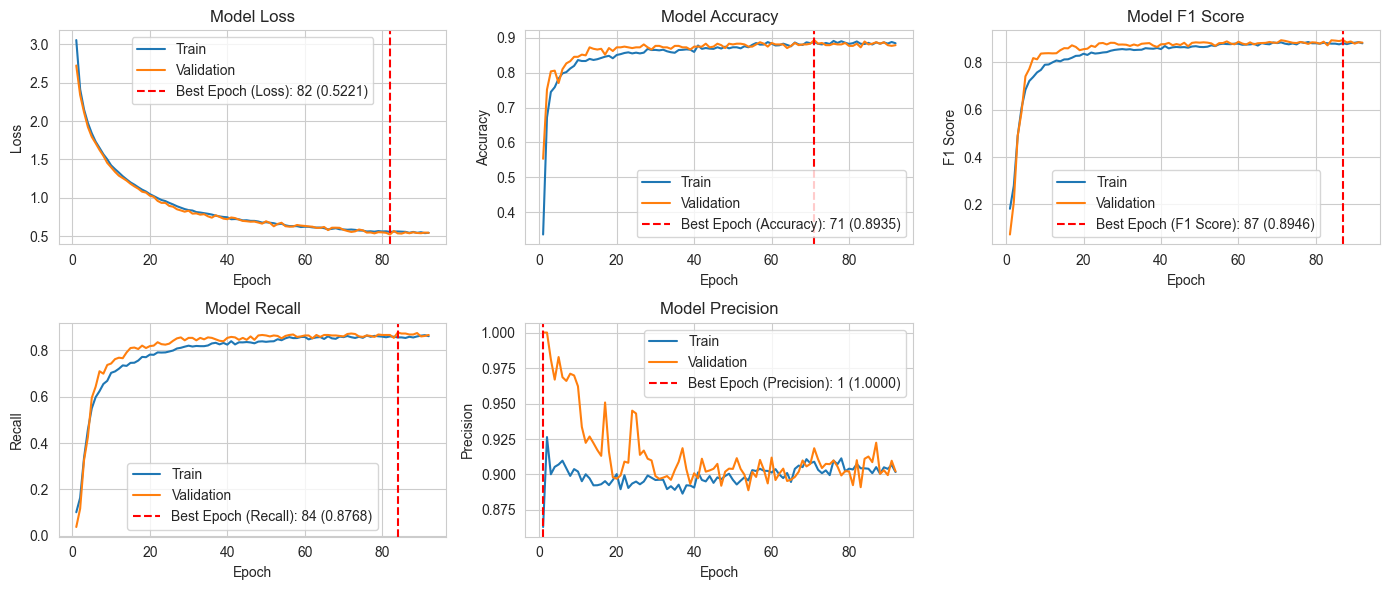

14/14 [==============================] - 0s 3ms/step - loss: 0.6512 - recall: 0.7902 - precision: 0.8737 - accuracy: 0.8531 - f1_score: 0.8299

=== Evaluation Metrics ===
loss: 0.6512
recall: 79.02%
precision: 87.37%
accuracy: 85.31%
f1_score: 82.99%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


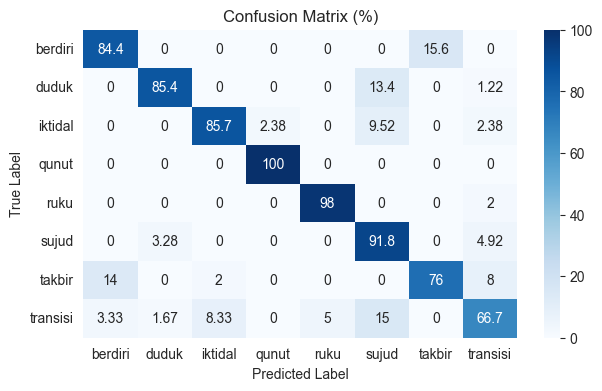


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-256bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 14:06:52.815178: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:06:52.815368: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:06:53.188942: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:06:53.189083: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-256bs-64hl/model.onnx

=== Done! ===


In [74]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=256,
    hidden_layer=64,
    use_cache=False,
)

#### Hidden Layer

##### 16hl

Model: "test2-model_0_myria-20ws-adagrad-0.01lr-32bs-16hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 32)                2560      
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 2824 (11.03 KB)
Trainable params: 2824 (11.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 60.05 seconds
Total epochs: 94


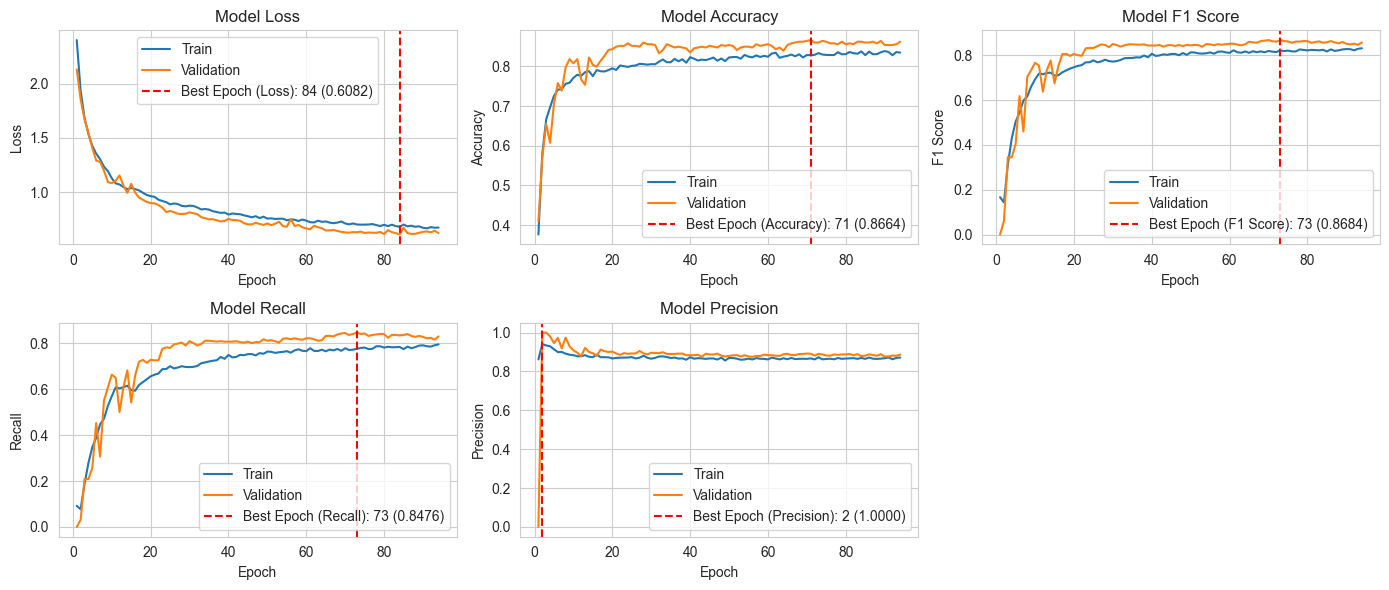

14/14 [==============================] - 0s 3ms/step - loss: 0.7846 - recall: 0.6923 - precision: 0.8462 - accuracy: 0.7809 - f1_score: 0.7615

=== Evaluation Metrics ===
loss: 0.7846
recall: 69.23%
precision: 84.62%
accuracy: 78.09%
f1_score: 76.15%

=== Confusion Matrix ===
14/14 [==============================] - 1s 2ms/step


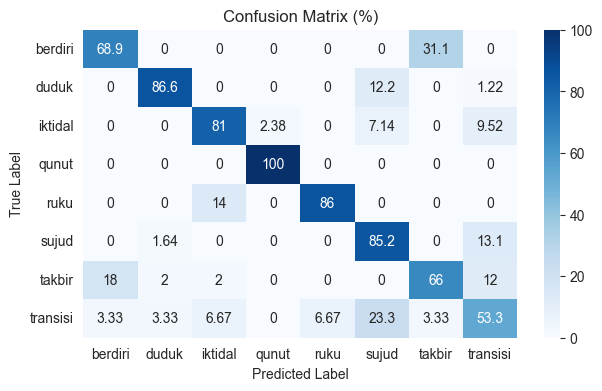


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-16hl/model.keras

Saving model as ONNX...


2024-07-07 14:04:14.991969: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-07 14:04:14.992094: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-07 14:04:15.398834: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-07 14:04:15.398959: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-16hl/model.onnx

=== Done! ===


In [62]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=32,
    hidden_layer=16,
    show_summary=True,
    use_cache=False,
)

##### 32hl

Model: "test2-model_0_myria-20ws-adagrad-0.01lr-32bs-32hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 64)                9216      
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 9736 (38.03 KB)
Trainable params: 9736 (38.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 57.72 seconds
Total epochs: 82


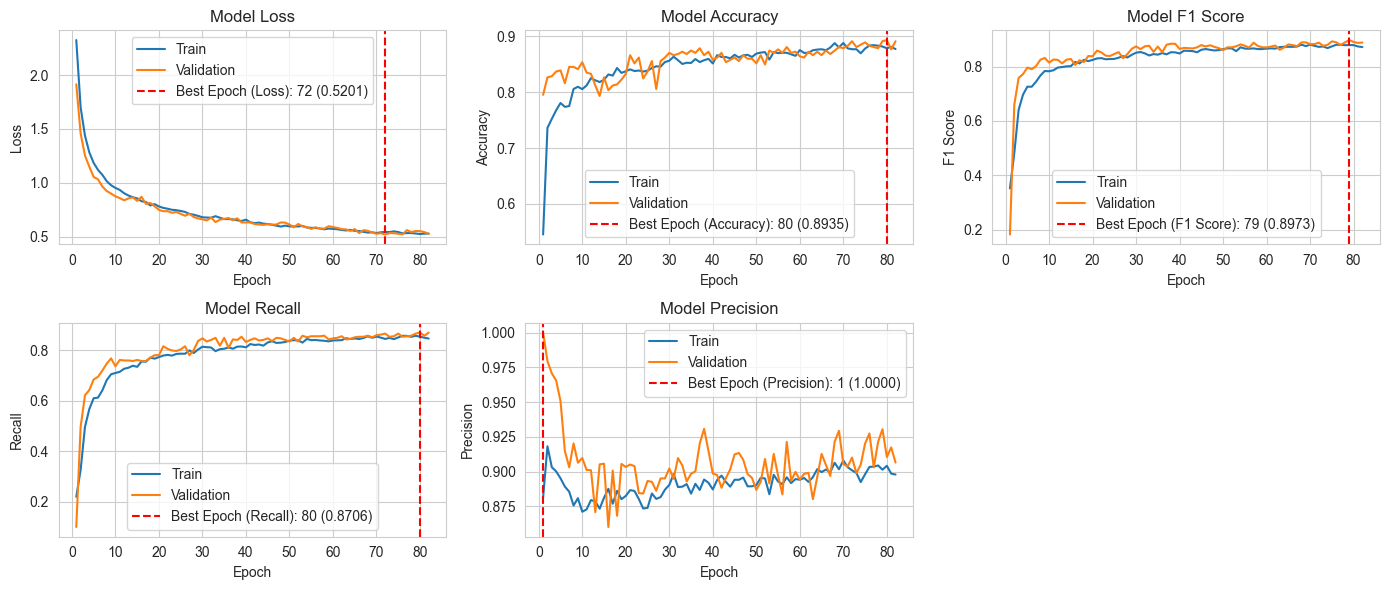

14/14 [==============================] - 0s 4ms/step - loss: 0.7279 - recall: 0.7692 - precision: 0.8250 - accuracy: 0.8089 - f1_score: 0.7961

=== Evaluation Metrics ===
loss: 0.7279
recall: 76.92%
precision: 82.50%
accuracy: 80.89%
f1_score: 79.61%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


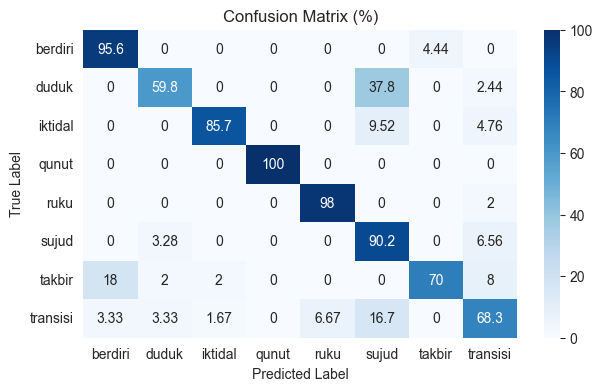


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-32hl/model.keras

Saving model as ONNX...


2024-07-07 14:06:17.932984: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-07 14:06:17.933158: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-07 14:06:18.358755: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-07 14:06:18.358874: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-32hl/model.onnx

=== Done! ===


In [64]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=32,
    hidden_layer=32,
    show_summary=True,
    use_cache=False,
)

##### 128hl

Model: "test2-model_0_myria-20ws-adagrad-0.01lr-32bs-128hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_19 (Bidirect  (None, 256)               135168    
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 137224 (536.03 KB)
Trainable params: 137224 (536.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 121.97 seconds
Total epochs: 65


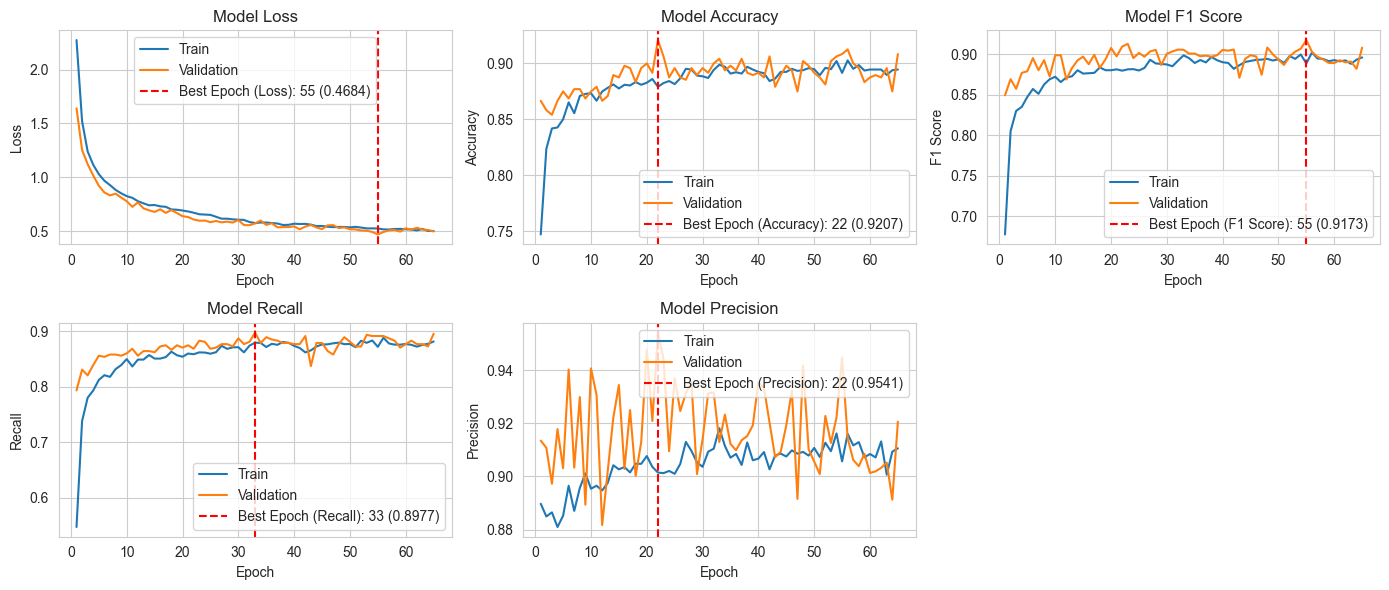

14/14 [==============================] - 0s 7ms/step - loss: 0.6310 - recall: 0.7786 - precision: 0.8930 - accuracy: 0.8205 - f1_score: 0.8319

=== Evaluation Metrics ===
loss: 0.6310
recall: 77.86%
precision: 89.30%
accuracy: 82.05%
f1_score: 83.19%

=== Confusion Matrix ===
14/14 [==============================] - 1s 5ms/step


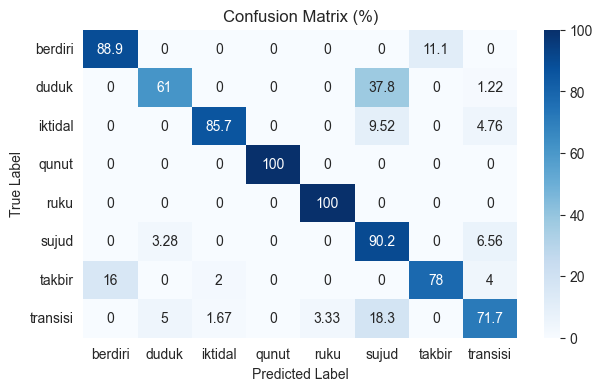


Saving model as keras...
Keras model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-128hl/model.keras

Saving model as ONNX...


2024-07-06 14:35:39.372382: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:35:39.372515: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:35:39.762177: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:35:39.762305: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test2-model_0_myria-20ws-adagrad-0.01lr-32bs-128hl/model.onnx

=== Done! ===


In [78]:
evaluate_test_model_adagrad(
    learning_rate=0.01,
    batch_size=32,
    hidden_layer=128,
    show_summary=True,
    use_cache=True,
)

### Adam


In [61]:
def evaluate_test_model_adam(learning_rate, batch_size, hidden_layer=64, show_summary=False, use_cache=False):
    model_name = (
        f"test-model_0_myria-20ws-adam-{learning_rate}lr-{batch_size}bs-{hidden_layer}hl"
    )

    model = create_model_0(
        model_name=model_name,
        window_size=20,
        n_hidden=hidden_layer,
    )

    if show_summary:
        model.summary()

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[recall, precision, "accuracy", f1],
    )

    model_path = start_train(
        model=model,
        X_train=X_train_20,
        Y_train=Y_train_20,
        X_test=X_test_20,
        Y_test=Y_test_20,
        X_val=X_val_20,
        Y_val=Y_val_20,
        use_cache=use_cache,
        epochs=1000,
        batch_size=batch_size,
        verbose=0,
    )

#### Learning Rate (default: 20ws, 32bs, 64hl)


##### 0.1lr


Training took 19.04 seconds
Total epochs: 11


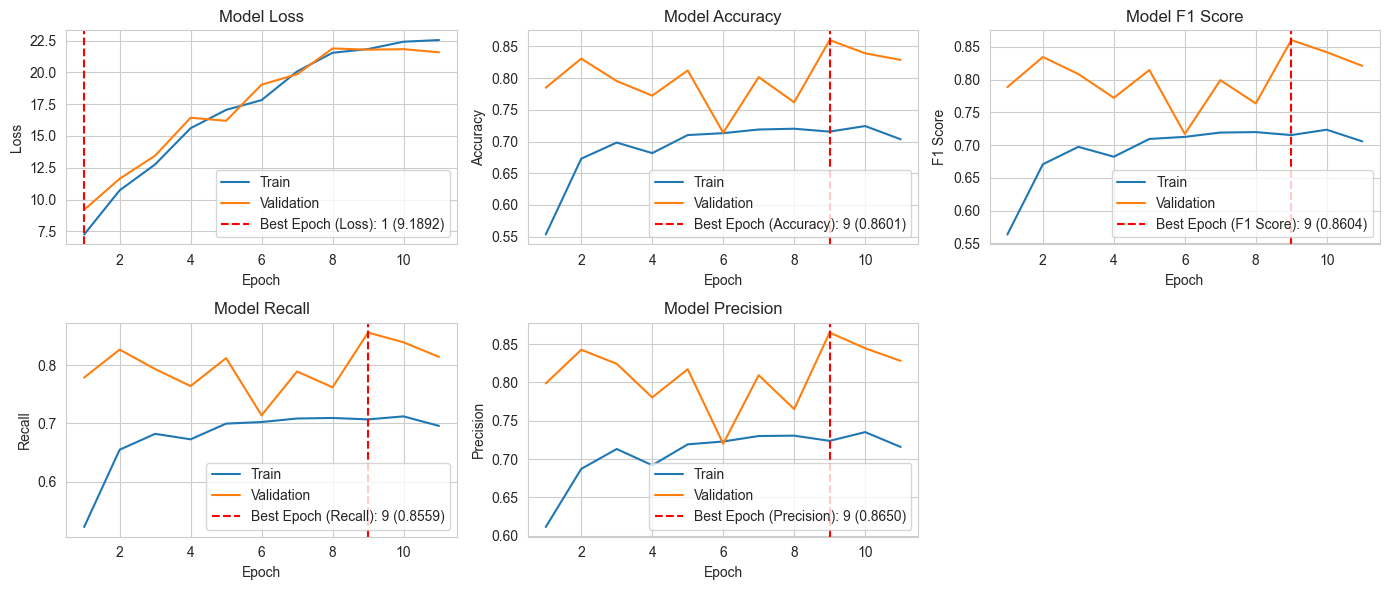

14/14 [==============================] - 0s 4ms/step - loss: 9.7172 - recall: 0.6224 - precision: 0.6544 - accuracy: 0.6270 - f1_score: 0.6380
{'loss': 9.717246055603027, 'recall': 0.6223776340484619, 'precision': 0.654411792755127, 'accuracy': 0.6270396113395691, 'f1_score': 0.6379928588867188}

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


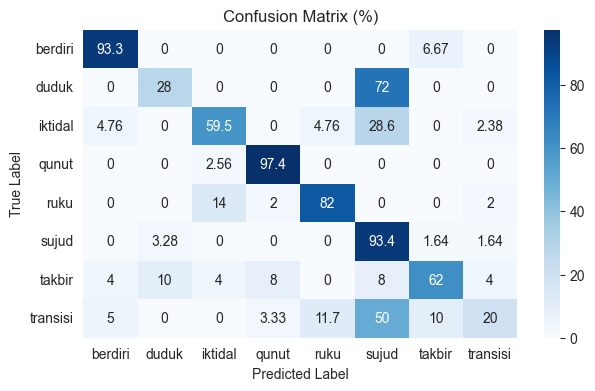


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.1lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 09:10:00.448985: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:10:00.449150: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 09:10:00.867225: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:10:00.867365: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.1lr-32bs-64hl/model.onnx

=== Done! ===


In [102]:
evaluate_test_model_adam(
    learning_rate=0.1,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

##### 0.01lr


Training took 15.36 seconds
Total epochs: 11


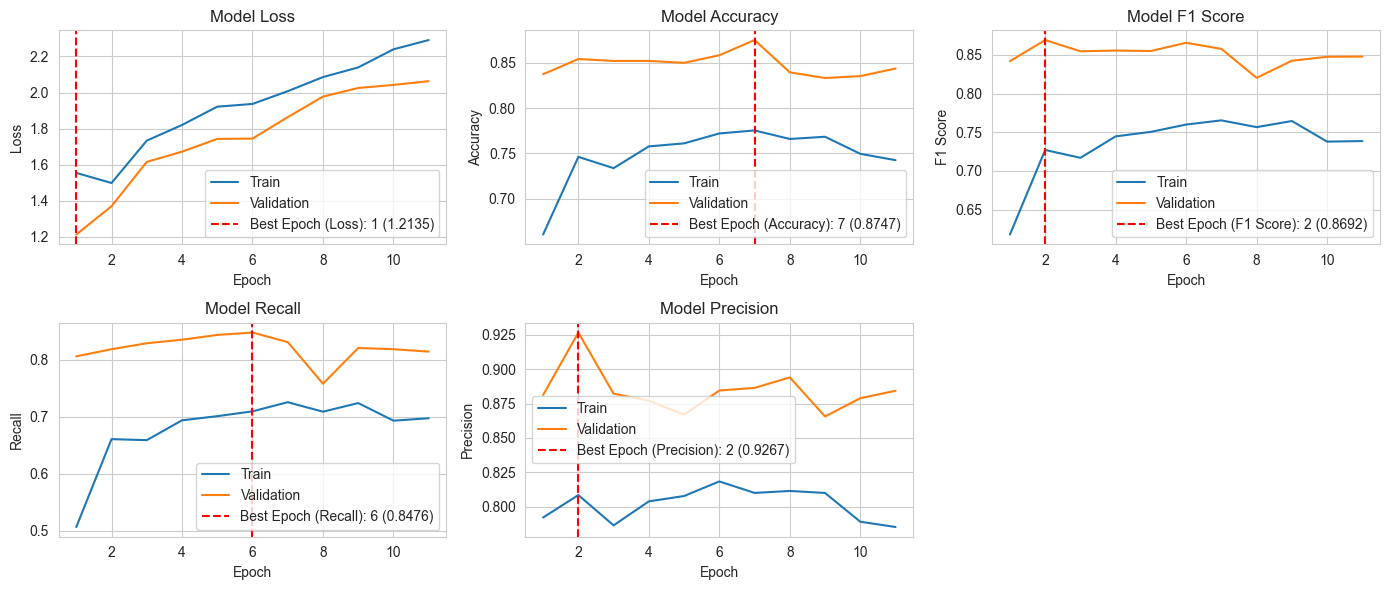

14/14 [==============================] - 0s 4ms/step - loss: 1.4780 - recall: 0.6154 - precision: 0.8000 - accuracy: 0.6527 - f1_score: 0.6957
{'loss': 1.47795832157135, 'recall': 0.6153846383094788, 'precision': 0.800000011920929, 'accuracy': 0.6526806354522705, 'f1_score': 0.695652186870575}

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


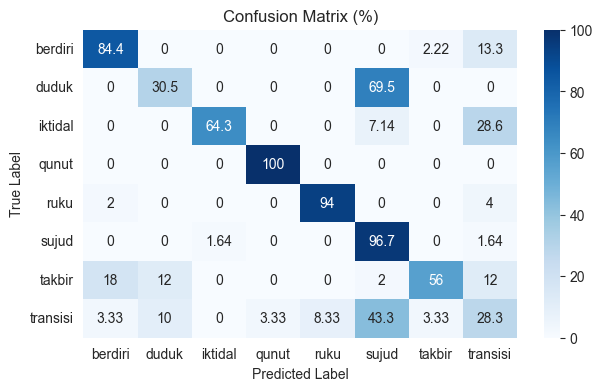


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.01lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 09:10:22.759097: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:10:22.759218: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 09:10:23.151823: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:10:23.151950: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.01lr-32bs-64hl/model.onnx

=== Done! ===


In [103]:
evaluate_test_model_adam(
    learning_rate=0.01,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

##### 0.001lr


Training took 38.01 seconds
Total epochs: 33


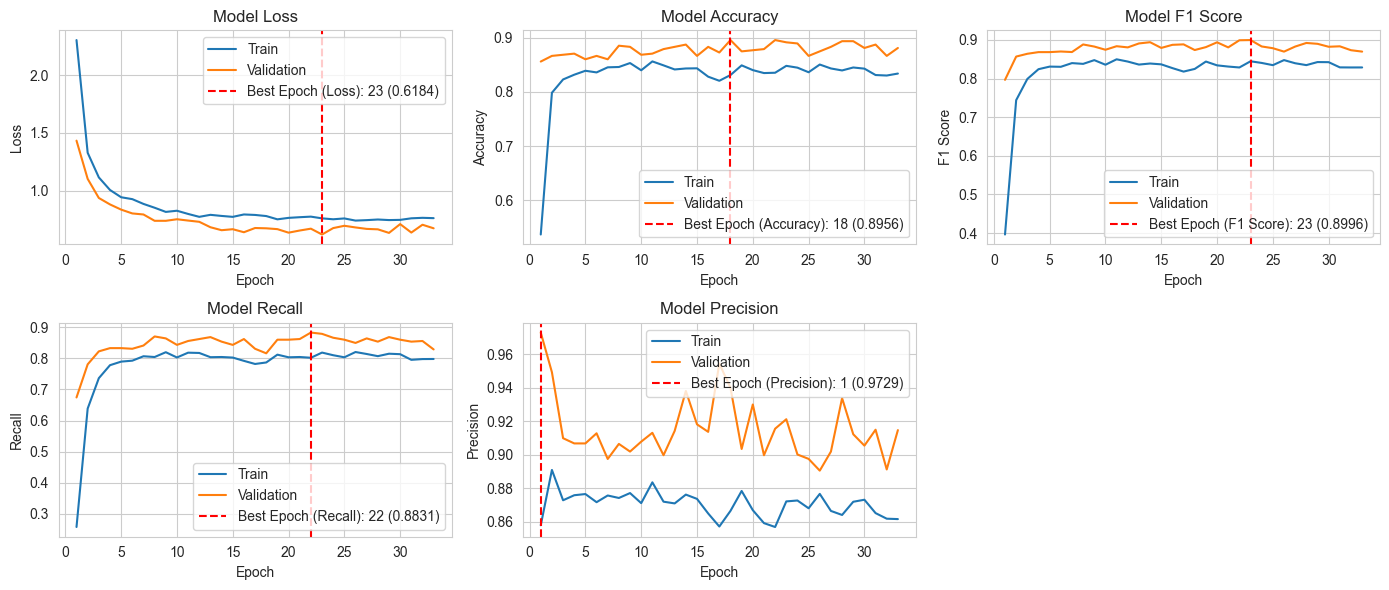

14/14 [==============================] - 0s 4ms/step - loss: 0.8131 - recall: 0.7855 - precision: 0.8532 - accuracy: 0.8205 - f1_score: 0.8180
{'loss': 0.8131011128425598, 'recall': 0.7855477929115295, 'precision': 0.853164553642273, 'accuracy': 0.8205128312110901, 'f1_score': 0.8179611563682556}

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


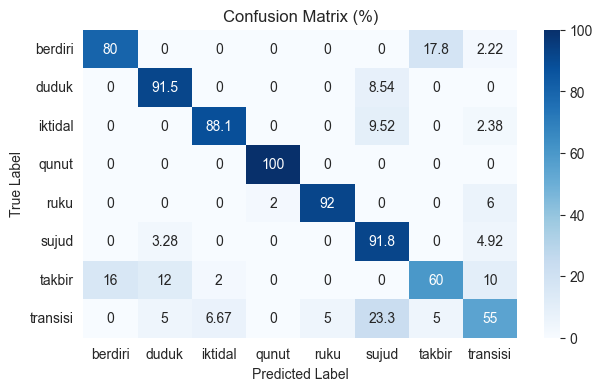


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.001lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 09:12:56.171217: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:12:56.171402: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 09:12:56.597296: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:12:56.597445: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.001lr-32bs-64hl/model.onnx

=== Done! ===


In [104]:
evaluate_test_model_adam(
    learning_rate=0.001,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

##### 0.0001lr


Training took 135.88 seconds
Total epochs: 139


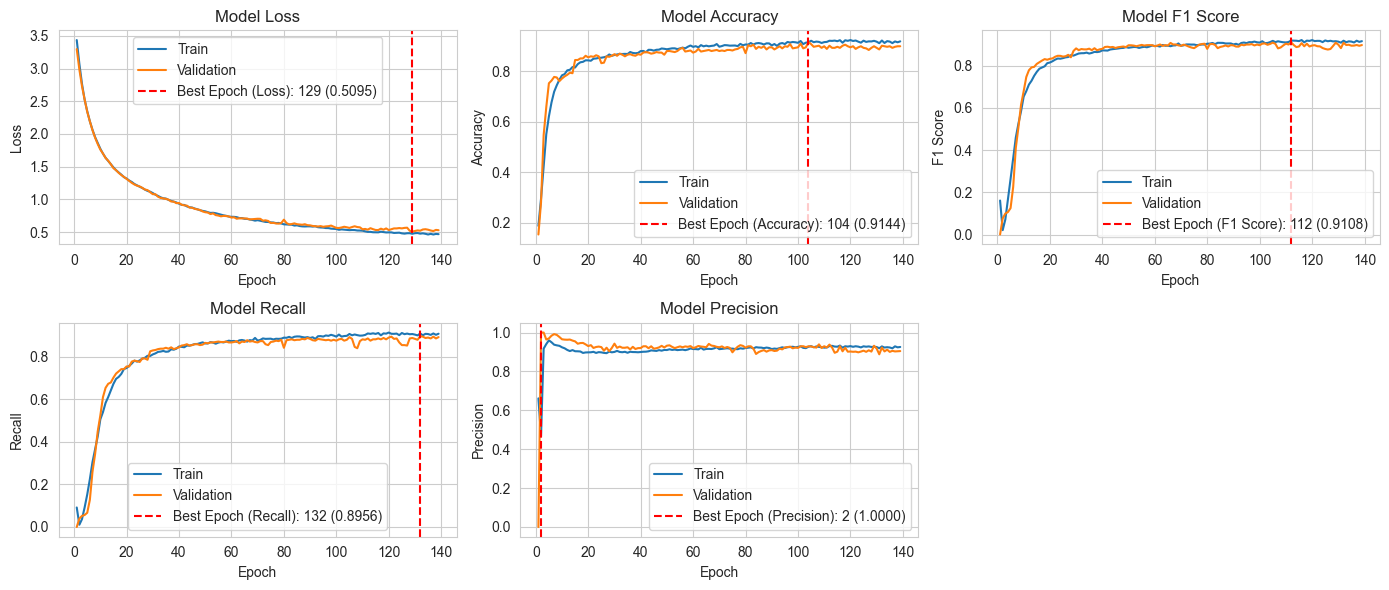

14/14 [==============================] - 0s 6ms/step - loss: 0.6371 - recall: 0.8298 - precision: 0.8922 - accuracy: 0.8625 - f1_score: 0.8599
{'loss': 0.6371479034423828, 'recall': 0.8298368453979492, 'precision': 0.8922305703163147, 'accuracy': 0.8624708652496338, 'f1_score': 0.8599033951759338}

=== Confusion Matrix ===
14/14 [==============================] - 1s 6ms/step


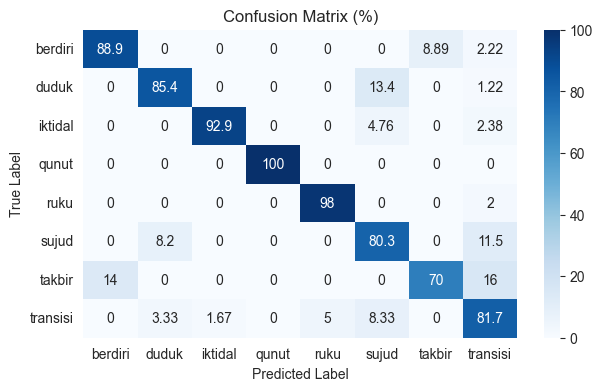


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 09:15:20.813496: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:15:20.813619: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 09:15:21.224791: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 09:15:21.224919: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-64hl/model.onnx

=== Done! ===


In [105]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=32,
    hidden_layer=64,
    use_cache=True,
)

#### Batch Size (default: 20ws, 0.0001lr, 64hl)


##### 64bs


Training took 84.09 seconds
Total epochs: 142


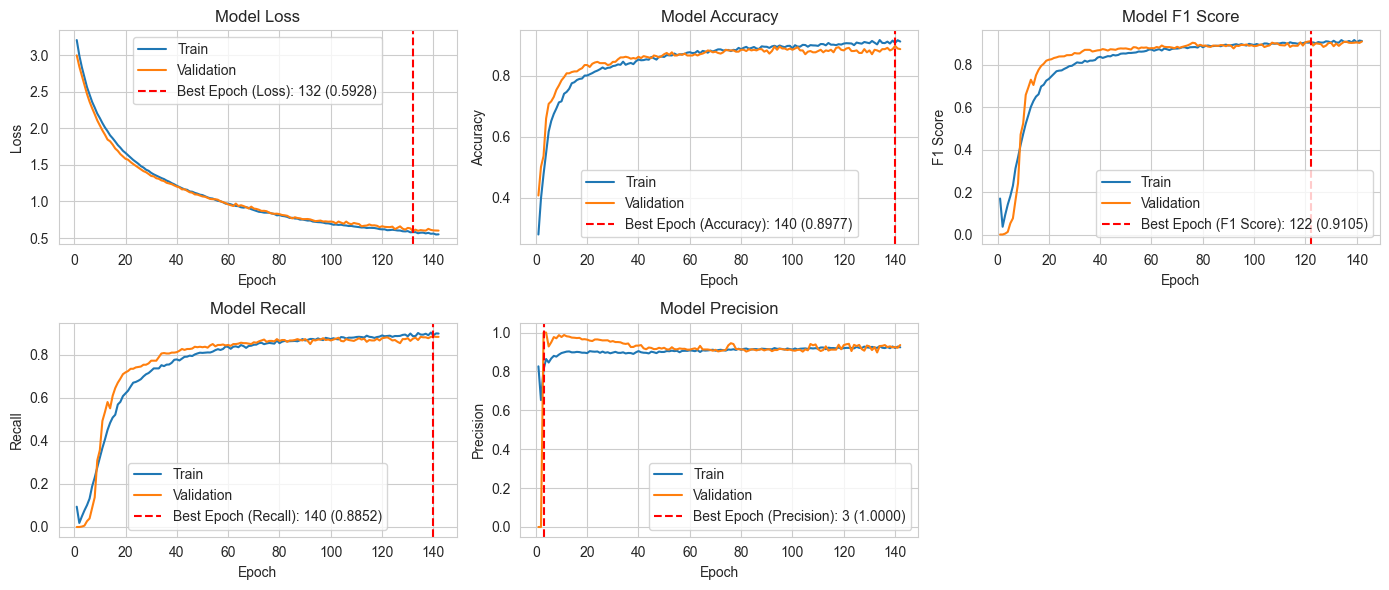

14/14 [==============================] - 0s 3ms/step - loss: 0.7688 - recall: 0.7949 - precision: 0.8927 - accuracy: 0.8298 - f1_score: 0.8409

=== Evaluation Metrics ===
loss: 0.7688
recall: 79.49%
precision: 89.27%
accuracy: 82.98%
f1_score: 84.09%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


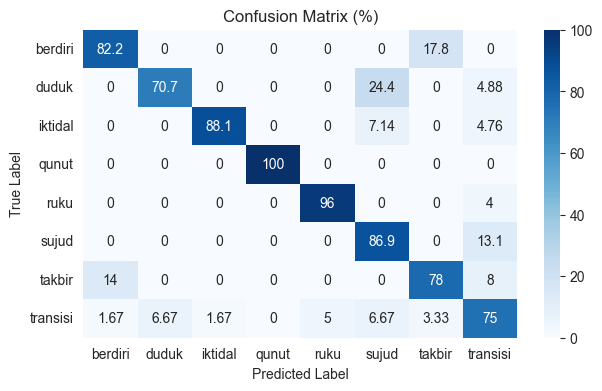


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-64bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 14:01:05.089157: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:01:05.089272: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:01:05.489803: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:01:05.489939: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-64bs-64hl/model.onnx

=== Done! ===


In [69]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=64,
    hidden_layer=64,
    use_cache=True,
)

##### 128bs


Training took 121.22 seconds
Total epochs: 234


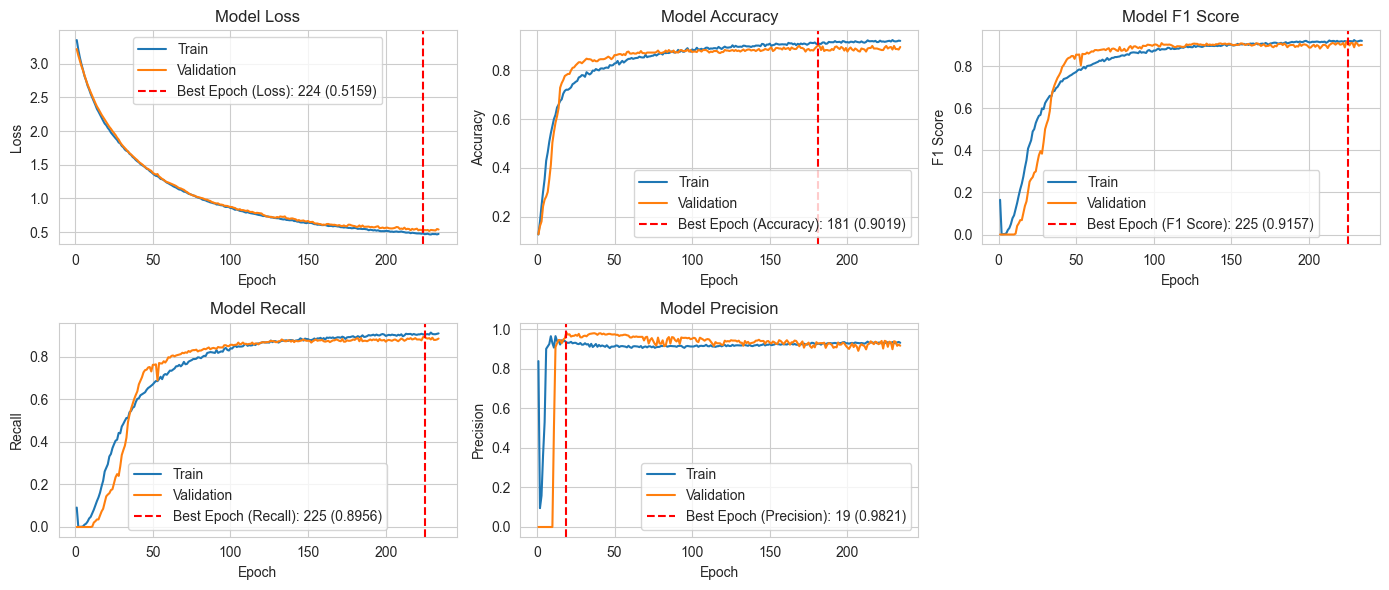

14/14 [==============================] - 0s 5ms/step - loss: 0.6718 - recall: 0.7972 - precision: 0.8403 - accuracy: 0.8112 - f1_score: 0.8182

=== Evaluation Metrics ===
loss: 0.6718
recall: 79.72%
precision: 84.03%
accuracy: 81.12%
f1_score: 81.82%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


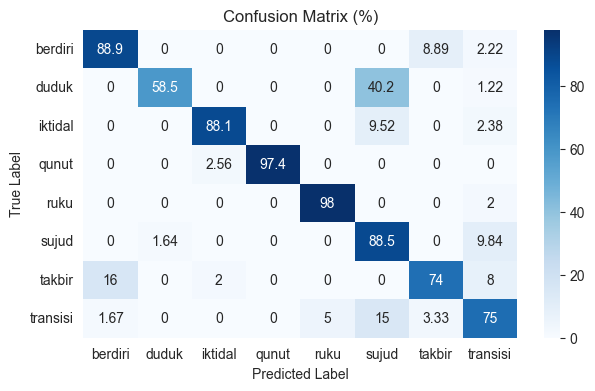


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-128bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 14:03:13.611065: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:03:13.611206: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:03:14.003607: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:03:14.003736: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-128bs-64hl/model.onnx

=== Done! ===


In [70]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=128,
    hidden_layer=64,
    use_cache=True,
)

##### 256bs


Training took 77.04 seconds
Total epochs: 192


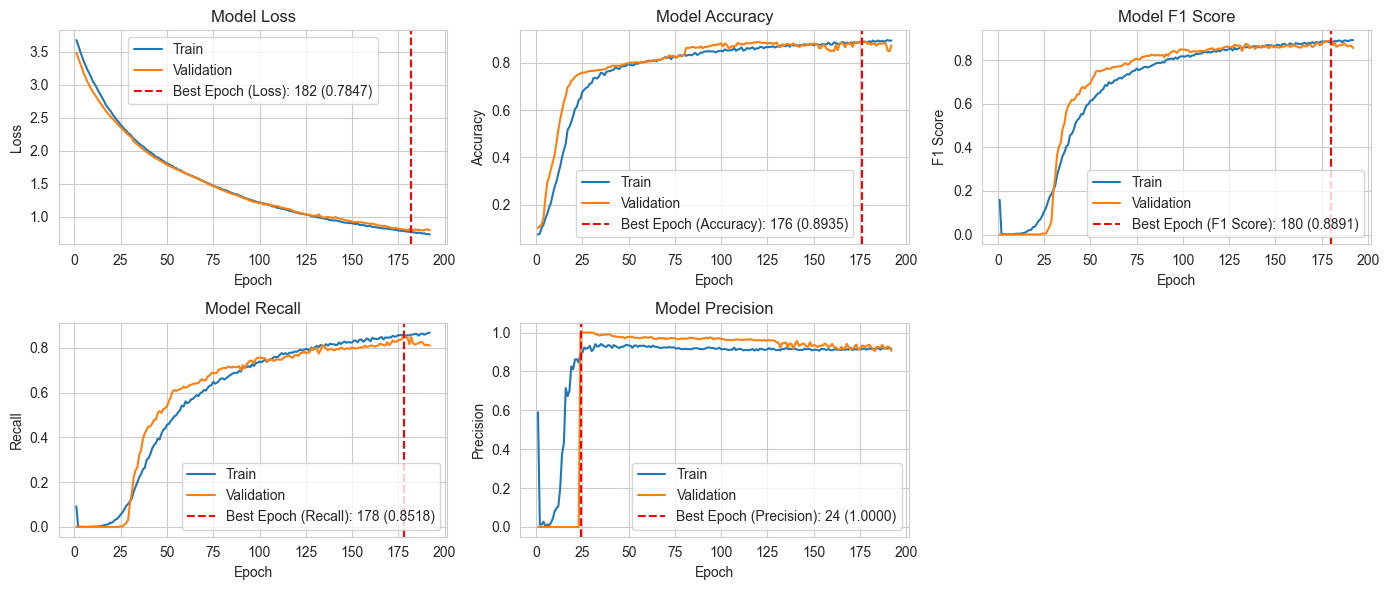

14/14 [==============================] - 0s 3ms/step - loss: 1.0013 - recall: 0.7483 - precision: 0.8966 - accuracy: 0.8159 - f1_score: 0.8158

=== Evaluation Metrics ===
loss: 1.0013
recall: 74.83%
precision: 89.66%
accuracy: 81.59%
f1_score: 81.58%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


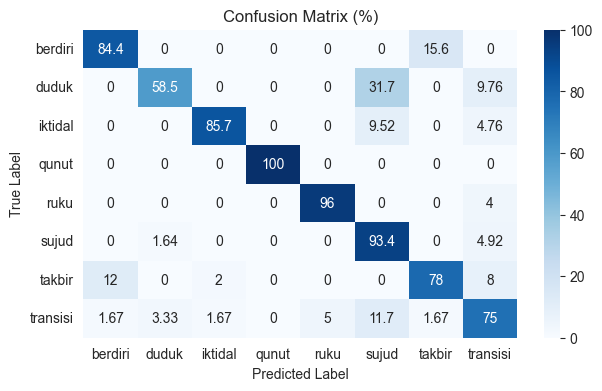


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-256bs-64hl/model.keras

Saving model as ONNX...


2024-07-06 14:04:38.303316: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:04:38.303464: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:04:38.692588: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:04:38.692721: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-256bs-64hl/model.onnx

=== Done! ===


In [71]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=256,
    hidden_layer=64,
    use_cache=True,
)

#### Hidden Layer (default: 20ws, 0.0001lr, 32bs)


##### 16hl


Model: "test-model_0_myria-20ws-adam-0.0001lr-32bs-16hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirect  (None, 32)                2560      
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 8)                 264       
                                                                 
Total params: 2824 (11.03 KB)
Trainable params: 2824 (11.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 102.46 seconds
Total epochs: 159


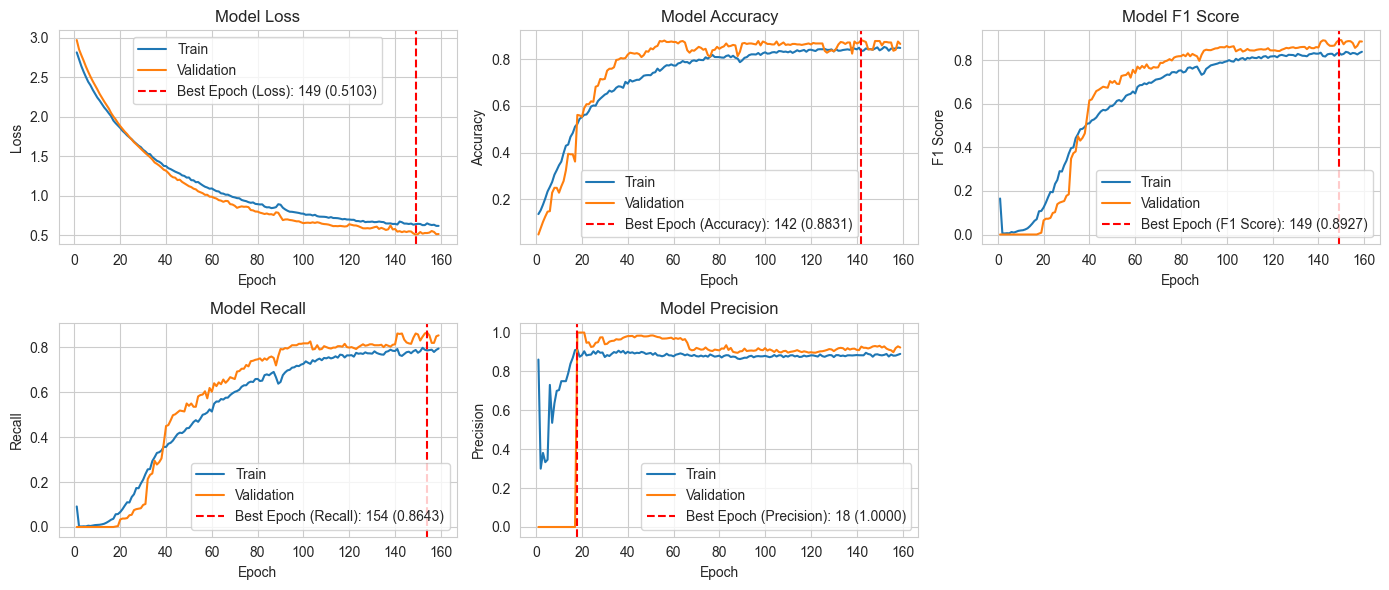

14/14 [==============================] - 0s 3ms/step - loss: 0.7236 - recall: 0.7273 - precision: 0.8789 - accuracy: 0.7646 - f1_score: 0.7959

=== Evaluation Metrics ===
loss: 0.7236
recall: 72.73%
precision: 87.89%
accuracy: 76.46%
f1_score: 79.59%

=== Confusion Matrix ===
14/14 [==============================] - 1s 3ms/step


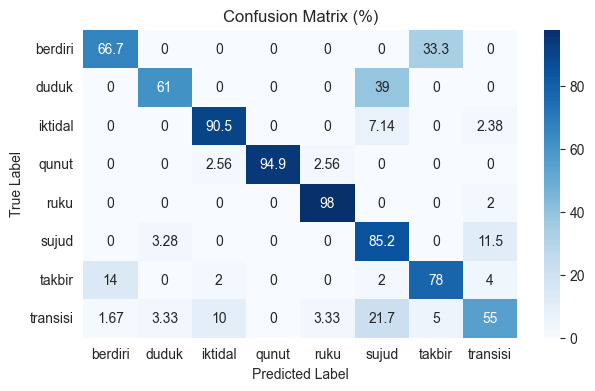


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-16hl/model.keras

Saving model as ONNX...


2024-07-06 14:37:30.487093: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:37:30.487255: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:37:30.910002: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:37:30.910133: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-16hl/model.onnx

=== Done! ===


In [79]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=32,
    hidden_layer=16,
    show_summary=True,
    use_cache=True,
)

##### 32hl


Model: "test-model_0_myria-20ws-adam-0.0001lr-32bs-32hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirect  (None, 64)                9216      
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 8)                 520       
                                                                 
Total params: 9736 (38.03 KB)
Trainable params: 9736 (38.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 84.44 seconds
Total epochs: 111


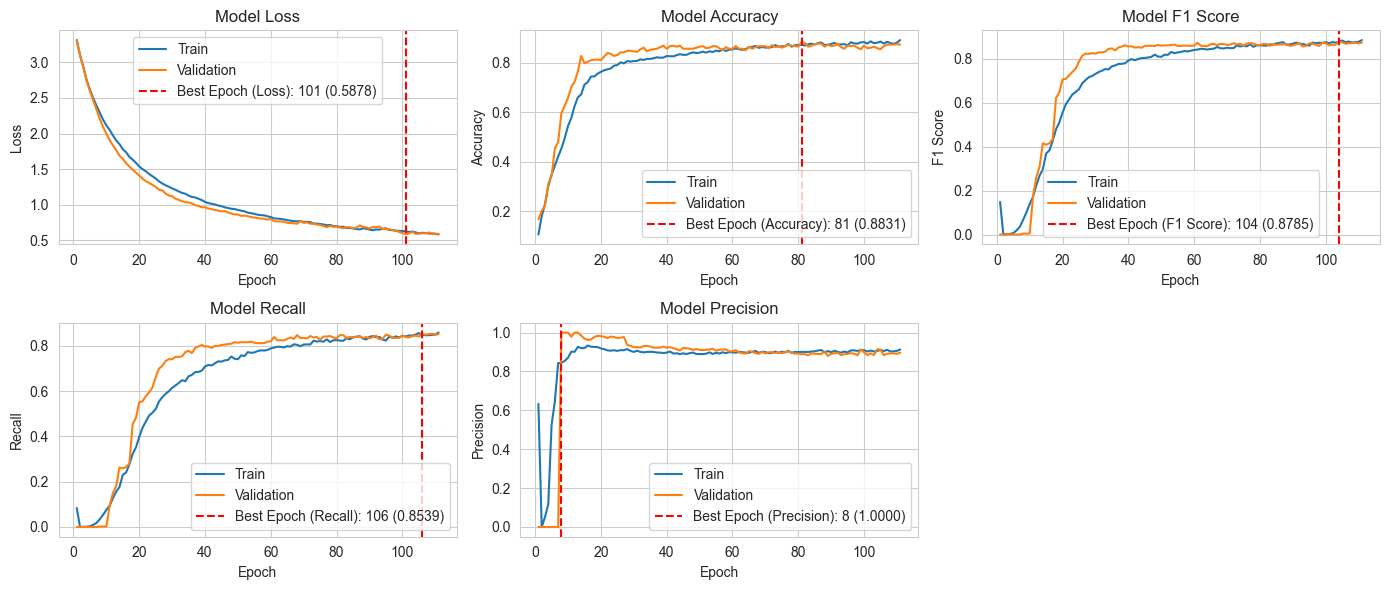

14/14 [==============================] - 0s 3ms/step - loss: 0.7982 - recall: 0.6900 - precision: 0.8000 - accuracy: 0.7832 - f1_score: 0.7409

=== Evaluation Metrics ===
loss: 0.7982
recall: 69.00%
precision: 80.00%
accuracy: 78.32%
f1_score: 74.09%

=== Confusion Matrix ===
14/14 [==============================] - 1s 2ms/step


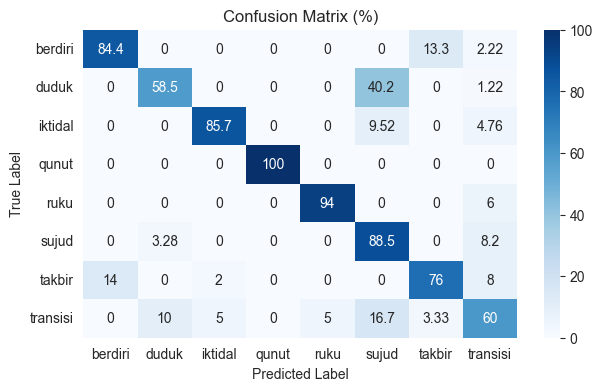


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-32hl/model.keras

Saving model as ONNX...


2024-07-06 14:39:01.660812: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:39:01.660953: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:39:02.061268: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:39:02.061397: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-32hl/model.onnx

=== Done! ===


In [80]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=32,
    hidden_layer=32,
    show_summary=True,
    use_cache=True,
)

##### 128hl


Model: "test-model_0_myria-20ws-adam-0.0001lr-32bs-128hl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirect  (None, 256)               135168    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 137224 (536.03 KB)
Trainable params: 137224 (536.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 307.74 seconds
Total epochs: 150


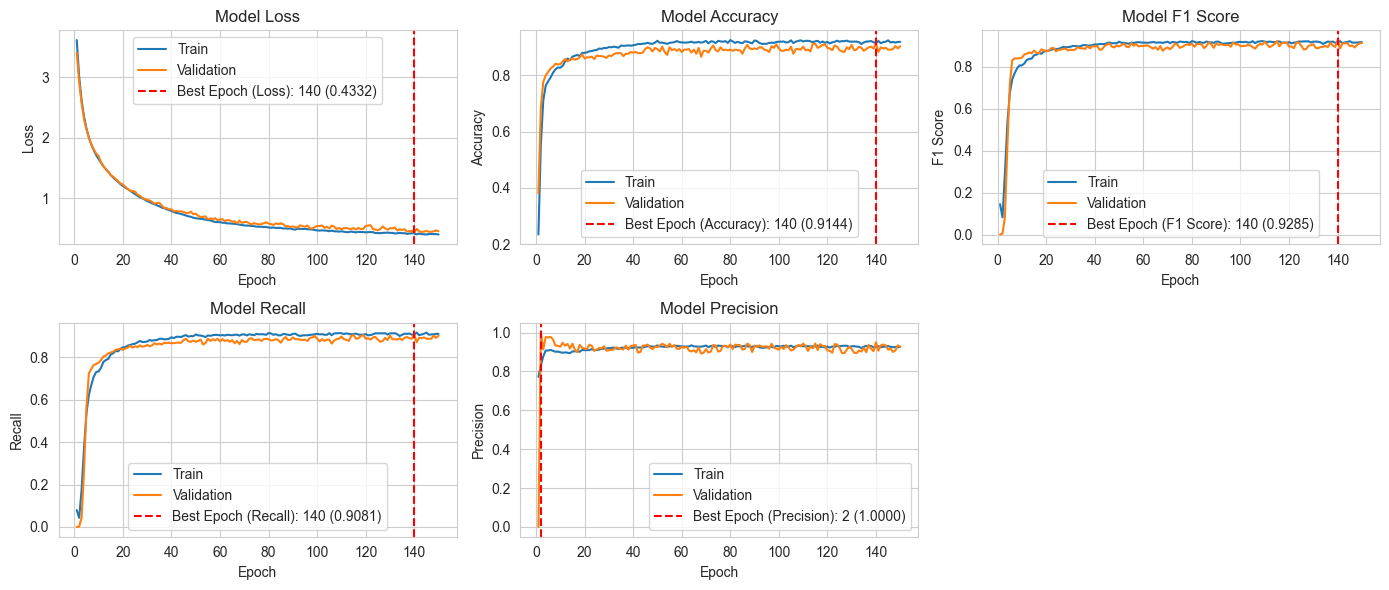

14/14 [==============================] - 0s 9ms/step - loss: 0.5829 - recall: 0.8112 - precision: 0.9062 - accuracy: 0.8438 - f1_score: 0.8561

=== Evaluation Metrics ===
loss: 0.5829
recall: 81.12%
precision: 90.62%
accuracy: 84.38%
f1_score: 85.61%

=== Confusion Matrix ===
14/14 [==============================] - 1s 8ms/step


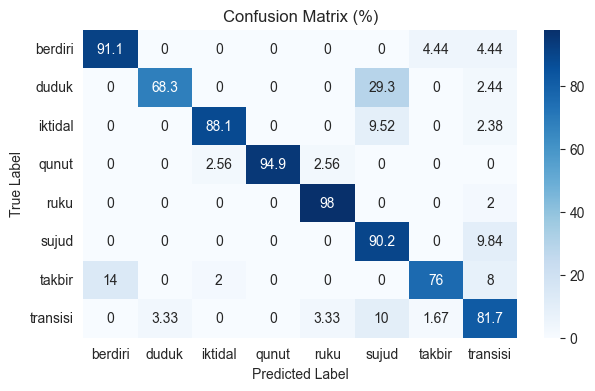


Saving model as keras...
Keras model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-128hl/model.keras

Saving model as ONNX...


2024-07-06 14:44:19.017544: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:44:19.017707: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-06 14:44:19.518132: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-06 14:44:19.518304: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


ONNX model saved successfully in ./models/test-model_0_myria-20ws-adam-0.0001lr-32bs-128hl/model.onnx

=== Done! ===


In [81]:
evaluate_test_model_adam(
    learning_rate=0.0001,
    batch_size=32,
    hidden_layer=128,
    show_summary=True,
    use_cache=True,
)

### Others

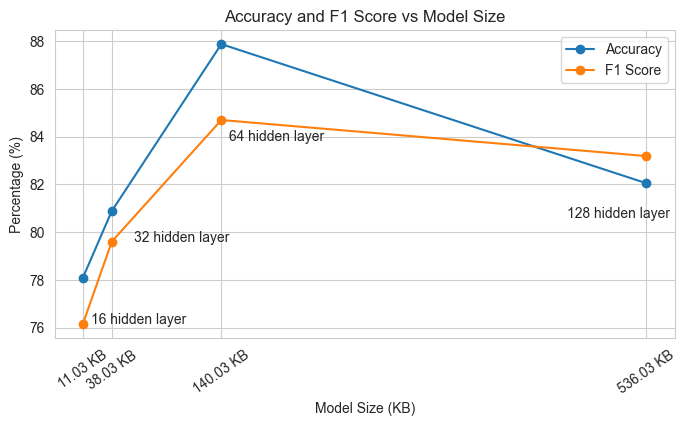

In [65]:
import matplotlib.pyplot as plt

# Data
model_sizes = [11.03, 38.03, 140.03, 536.03]
accuracy = [78.09, 80.89, 87.88, 82.05]
f1_score = [76.15, 79.61, 84.70, 83.19]
hidden_layer = [16, 32, 64, 128]

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(model_sizes, accuracy, marker="o", label="Accuracy")
plt.plot(model_sizes, f1_score, marker="o", label="F1 Score")

# Adding titles and labels
plt.title("Accuracy and F1 Score vs Model Size")
plt.xlabel("Model Size (KB)")
plt.ylabel("Percentage (%)")
plt.legend()

plt.annotate(
    f"16 hidden layer",
    (model_sizes[0], min(accuracy[0], f1_score[0])),
    textcoords="offset points",
    xytext=(40, 0),
    ha="center",
)

plt.annotate(
    f"32 hidden layer",
    (model_sizes[1], min(accuracy[1], f1_score[1])),
    textcoords="offset points",
    xytext=(50, 0),
    ha="center",
)

plt.annotate(
    f"64 hidden layer",
    (model_sizes[2], min(accuracy[2], f1_score[2])),
    textcoords="offset points",
    xytext=(40, -15),
    ha="center",
)

plt.annotate(
    f"128 hidden layer",
    (model_sizes[3], min(accuracy[3], f1_score[3])),
    textcoords="offset points",
    xytext=(-20, -25),
    ha="center",
)

plt.xticks(model_sizes, [f"{size} KB" for size in model_sizes])
plt.xticks(rotation=35)

# Show grid
plt.grid(True)

# Show plot
plt.show()